# Visualization DataFrame Creation
This notebook is dedicated to the creation of a pandas DataFrame to be used for the visualization of the RAIS dataset. The data will be presented on a per-user and per-day basis (daily granularity). The dataframe includes all collected data types, such as Fitbit data, SEMA data, and surveys data.

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import pickle
import gc
import numpy as np
import swifter
import pickle
import seaborn as sns
import pandas as pd
from datetime import datetime
import matplotlib.ticker as mticker
import matplotlib.dates as md
from tqdm import tqdm
from pymongo import MongoClient
from datetime import datetime
import json
from datetime import date
from bson import ObjectId

from definitions import ROOT_DIR

## Setting Current Working Directory
Changing CWD to root

In [2]:
os.chdir(ROOT_DIR)

In [3]:
ROOT_DIR

'C:\\Users\\Sofia\\PycharmProjects\\RAIS-EDA'

## Connecting to MongoDB

In [4]:
with open('credentials.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']

# Connection to raisv2 database
client = MongoClient('mongodb://%s:%s@127.0.0.1' % (username, password))
db = client.raisV3_anonymized

In [5]:
users = db.fitbit.distinct('id')

## Integrating Fitbit Data
Fitbit includes a variety of information, such as physical activity, sleep, and stress patterns, as well data about SpO2, EDA, VO2 max, etc., at different granularities. Here we read each data type and integrate it into our visualization DataFrame with daily granularity.

### Computed Temperature
The night skin temperature of the user during sleep (N=4332).

In [6]:
# Reading temperature data from MongoDB
users_skin_temperature = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
                    db.fitbit.find({ "$and": [
                        { "type": "Computed Temperature"},
                        {"data.type": "SKIN"},
                        {"id": user}
                    ] },
                        {"id": 1, "data.nightly_temperature": 1, "data.sleep_end": 1, "_id": 0}
                    )
                ))

    users_skin_temperature = pd.concat([users_skin_temperature, user_data], axis=0)

# split data column (json format) into two columns
users_skin_temperature["date"] = users_skin_temperature["data"].apply(lambda d: d["sleep_end"])
users_skin_temperature["nightly_temperature"] = users_skin_temperature["data"].apply(lambda d: d["nightly_temperature"])
users_skin_temperature.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_skin_temperature["date"] = pd.to_datetime(pd.to_datetime(users_skin_temperature["date"]).dt.date)

In [7]:
# view
users_skin_temperature.head()

,id,date,nightly_temperature
0,621e2e8e67b776a24055b564,2021-05-25,33.794544
1,621e2e8e67b776a24055b564,2021-05-29,34.610929
2,621e2e8e67b776a24055b564,2021-06-01,34.284452
3,621e2e8e67b776a24055b564,2021-06-05,34.218655
4,621e2e8e67b776a24055b564,2021-06-09,34.056346


In [8]:
# merge with df
df = users_skin_temperature
print("Size after integrating skin temperature: {}".format(df.shape[0]))

Size after integrating skin temperature: 3500


In [9]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'nightly_temperature'], keep=False)].shape[0]))

Duplicates based on ID and Date: 280
Duplicates based on ID and Date and Value: 280


In [10]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 3500
Size after duplicate elimination: 3359


### Daily Heart Rate Variability Summary
The heart rate variability of the user (N=2891).

In [11]:
users_HRV = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Daily Heart Rate Variability Summary"},
            {"id": user}
        ]},
            {"id": 1, "data.timestamp": 1, "data.nremhr": 1, "data.rmssd": 1, "_id": 0}
        )
    ))

    users_HRV = pd.concat([users_HRV, user_data], axis=0)

# split data column (json format) into two columns
users_HRV["date"] = users_HRV["data"].apply(lambda d: d["timestamp"])
users_HRV["nremhr"] = users_HRV["data"].apply(lambda d: d["nremhr"])
users_HRV["rmssd"] = users_HRV["data"].apply(lambda d: d["rmssd"])
users_HRV.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_HRV["date"] = pd.to_datetime(pd.to_datetime(users_HRV["date"]).dt.date)

In [12]:
# view
users_HRV.head()

,id,date,nremhr,rmssd
0,621e2e8e67b776a24055b564,2021-05-26,57.481,119.212
1,621e2e8e67b776a24055b564,2021-05-29,57.314,89.941
2,621e2e8e67b776a24055b564,2021-06-01,56.507,117.717
3,621e2e8e67b776a24055b564,2021-06-04,56.439,102.604
4,621e2e8e67b776a24055b564,2021-06-07,53.976,122.089


In [13]:
# merge
df = df.merge(users_HRV, how='outer', on=['id', 'date'])

In [14]:
# view merged
df.head(50)

,id,date,nightly_temperature,nremhr,rmssd
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776


In [15]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'nremhr', 'rmssd'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Daily SpO2
Daily oxygen saturation levels of the user (N=1606).

In [16]:
users_spo2 = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Daily SpO2"},
            {"id": user}
        ]},
            {"id": 1, "data.timestamp": 1, "data.average_value": 1, "_id": 0}
        )
    ))

    users_spo2 = pd.concat([users_spo2, user_data], axis=0)

# split data column (json format) into two columns
users_spo2["date"] = users_spo2["data"].apply(lambda d: d["timestamp"])
users_spo2["spo2"] = users_spo2["data"].apply(lambda d: d["average_value"])
users_spo2.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_spo2["date"] = pd.to_datetime(pd.to_datetime(users_spo2["date"]).dt.date)

In [17]:
# view
users_spo2.head()

,id,date,spo2
0,621e2ef567b776a24099f889,2021-10-19,97.7
0,621e2efa67b776a2409dd1c3,2021-05-26,96.7
1,621e2efa67b776a2409dd1c3,2021-05-30,96.9
2,621e2efa67b776a2409dd1c3,2021-06-03,94.0
3,621e2efa67b776a2409dd1c3,2021-06-11,96.7


In [18]:
# merge
df = df.merge(users_spo2, how='outer', on=['id', 'date'])

In [19]:
df.head(300)

,id,date,nightly_temperature,nremhr,rmssd,spo2
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN
...,...,...,...,...,...,...
295,621e2f1b67b776a240b3d87c,2021-11-16,33.245103,70.701,18.475,NaN
296,621e2f1b67b776a240b3d87c,2021-11-17,33.993565,64.381,19.816,NaN
297,621e2f1b67b776a240b3d87c,2021-11-18,33.136246,68.733,19.553,NaN
298,621e2f1b67b776a240b3d87c,2021-11-19,34.352762,62.164,26.027,NaN


In [20]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.drop_duplicates()
no_dups[no_dups.duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2


In [21]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 3479
Size after duplicate elimination: 3475


### Respiratory Rate Summary
Data about sleep breathing (N=3517).

In [22]:
users_respiratory_rate = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Respiratory Rate Summary"},
            {"id": user}
        ]},
            {"id": 1, "data.timestamp": 1, "data.full_sleep_breathing_rate": 1, "_id": 0}
        )
    ))

    users_respiratory_rate = pd.concat([users_respiratory_rate, user_data], axis=0)

# split data column (json format) into two columns
users_respiratory_rate["date"] = users_respiratory_rate["data"].apply(lambda d: d["timestamp"])
users_respiratory_rate["full_sleep_breathing_rate"] = users_respiratory_rate["data"].apply(lambda d: d["full_sleep_breathing_rate"])
users_respiratory_rate.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_respiratory_rate["date"] = pd.to_datetime(pd.to_datetime(users_respiratory_rate["date"]).dt.date)

In [23]:
users_respiratory_rate.head()

,id,date,full_sleep_breathing_rate
0,621e2e8e67b776a24055b564,2021-05-24,14.8
1,621e2e8e67b776a24055b564,2021-05-27,14.8
2,621e2e8e67b776a24055b564,2021-05-30,15.2
3,621e2e8e67b776a24055b564,2021-06-02,15.0
4,621e2e8e67b776a24055b564,2021-06-05,14.2


In [24]:
# merge
df = df.merge(users_respiratory_rate, how='outer', on=['id', 'date'])

In [25]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4
9,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4


In [26]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'full_sleep_breathing_rate'], keep=False)].shape[0]))

Duplicates based on ID and Date: 973
Duplicates based on ID and Date and Value: 816


Note: Here we notice that we have duplicate (user_id, date) rows but with different values.

In [27]:
no_dups = df.drop_duplicates()
no_dups[no_dups.duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate
138,621e2eaf67b776a2406b14ac,2021-12-17,34.297806,70.880,30.518,NaN,14.4
139,621e2eaf67b776a2406b14ac,2021-12-17,34.297806,70.880,30.518,NaN,14.8
160,621e2eaf67b776a2406b14ac,2022-01-08,33.519558,0.000,32.229,NaN,14.2
161,621e2eaf67b776a2406b14ac,2022-01-08,33.519558,0.000,32.229,NaN,0.0
185,621e2ed667b776a24085d8d1,2021-06-06,34.422184,82.094,0.000,NaN,0.0
...,...,...,...,...,...,...,...
3703,621e367e67b776a24087d75d,2021-06-06,33.199437,59.862,41.776,NaN,12.0
3789,621e367e67b776a24087d75d,2021-12-29,33.749619,76.608,12.992,NaN,12.6
3790,621e367e67b776a24087d75d,2021-12-29,33.749619,76.608,12.992,NaN,13.4
3939,621e375b67b776a240290cdc,2021-06-19,34.495627,65.800,19.570,NaN,16.4


In [28]:
# keep max to avoid 0 breathing rates
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 3981
Size after duplicate elimination: 3476


### Stress Score
Fitbit Sense users see a daily Stress Management Score (N=2578) in the Fitbit app ranging from 1 to 100 - where a higher number means you’re showing fewer physical signs of stress. It’s calculated based on three metrics: your Responsiveness (score out of 30), Exertion Balance (score out of 40) and Sleep Patterns (score out of 30).

In [29]:
users_stress = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Stress Score"},
            {"id": user}
        ]},
            {"id": 1, "data.DATE": 1, "data.STRESS_SCORE": 1, "data.SLEEP_POINTS": 1, "data.MAX_SLEEP_POINTS": 1, "data.EXERTION_POINTS": 1, "data.MAX_EXERTION_POINTS": 1, "data.RESPONSIVENESS_POINTS": 1, "data.MAX_RESPONSIVENESS_POINTS": 1, "_id": 0}
        )
    ))

    users_stress = pd.concat([users_stress, user_data], axis=0)

users_avg_max_sleep_points = np.mean(users_stress["data"].apply(lambda d: d["MAX_SLEEP_POINTS"]))
users_avg_max_exertion_points = np.mean(users_stress["data"].apply(lambda d: d["MAX_EXERTION_POINTS"]))
users_avg_max_responsiveness_points = np.mean(users_stress["data"].apply(lambda d: d["MAX_RESPONSIVENESS_POINTS"]))

# split data column (json format) into two columns
users_stress["date"] = users_stress["data"].apply(lambda d: d["DATE"])
users_stress["stress_score"] = users_stress["data"].apply(lambda d: d["STRESS_SCORE"])
users_stress["sleep_points_percentage"] = users_stress["data"].apply(lambda d: d["SLEEP_POINTS"]/d["MAX_SLEEP_POINTS"] if d["MAX_SLEEP_POINTS"] != 0 else d["SLEEP_POINTS"]/users_avg_max_sleep_points)
users_stress["exertion_points_percentage"] = users_stress["data"].apply(lambda d: d["EXERTION_POINTS"]/d["MAX_EXERTION_POINTS"] if d["MAX_EXERTION_POINTS"] != 0 else d["EXERTION_POINTS"]/users_avg_max_exertion_points)
users_stress["responsiveness_points_percentage"] = users_stress["data"].apply(lambda d: d["RESPONSIVENESS_POINTS"]/d["MAX_RESPONSIVENESS_POINTS"] if d["MAX_RESPONSIVENESS_POINTS"] != 0 else d["RESPONSIVENESS_POINTS"]/users_avg_max_responsiveness_points)
users_stress.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_stress["date"] = pd.to_datetime(pd.to_datetime(users_stress["date"]).dt.date)

In [30]:
users_stress.head()

,id,date,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage
0,621e2e8e67b776a24055b564,2021-05-26,84,0.966667,0.725,0.866667
1,621e2e8e67b776a24055b564,2021-05-29,82,0.900000,0.750,0.833333
2,621e2e8e67b776a24055b564,2021-06-01,84,0.833333,0.800,0.900000
3,621e2e8e67b776a24055b564,2021-06-04,78,0.833333,0.775,0.733333
4,621e2e8e67b776a24055b564,2021-06-07,79,0.900000,0.650,0.866667


In [31]:
# merge
df = df.merge(users_stress, how='outer', on=['id', 'date'])

In [32]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667


In [33]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'stress_score'], keep=False)].shape[0]))

Duplicates based on ID and Date: 70
Duplicates based on ID and Date and Value: 70


In [34]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 3566
Size after duplicate elimination: 3531


### Wrist Temperature
Data about the skin temperature of the user during the day (N=5,217,923). The value refers to the difference between the measured value and the user’s 30-day baseline (unknown where the baseline is stored or how it is calculated). The data are stored at a 3-minute granularity.

In [35]:
if os.path.exists('data/users_temperature.pkl'):
    print("Reading from pickle...")
    users_wrist_temperature = pd.read_pickle("data/users_temperature.pkl")
else:
    users_wrist_temperature = pd.DataFrame(columns=["id", "data"])
    for user in users:
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"type": "Wrist Temperature"},
                {"id": user}
            ]},
                {"id": 1, "data.recorded_time": 1, "data.temperature": 1, "_id": 0}
            )
        ))

        users_wrist_temperature = pd.concat([users_wrist_temperature, user_data], axis=0)

    # split data column (json format) into two columns
    users_wrist_temperature["date"] = users_wrist_temperature["data"].swifter.apply(lambda d: d["recorded_time"])
    users_wrist_temperature["daily_temperature_variation"] = users_wrist_temperature["data"].swifter.apply(lambda d: d["temperature"])
    users_wrist_temperature.drop(["data"], inplace=True, axis=1)

    # convert timestamp date object and then to datetime64[ns]
    users_wrist_temperature["date"] = pd.to_datetime(pd.to_datetime(users_wrist_temperature["date"]).dt.date, infer_datetime_format=True)

C:\ProgramData\Anaconda3\envs\RAIS-Data-Analysis\lib\site-packages\swifter\swifter.py:35: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4372238 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4372238 [00:00<?, ?it/s]

In [36]:
users_wrist_temperature.head()

,id,date,daily_temperature_variation
0,621e2e8e67b776a24055b564,2021-05-24,-1.189795
1,621e2e8e67b776a24055b564,2021-05-24,-1.179795
2,621e2e8e67b776a24055b564,2021-05-24,-1.114795
3,621e2e8e67b776a24055b564,2021-05-24,-1.019795
4,621e2e8e67b776a24055b564,2021-05-24,-1.019795


In [37]:
users_wrist_temperature.to_pickle("data/users_temperature.pkl")

In [38]:
# group by date and then take the average
users_wrist_temperature = users_wrist_temperature.groupby(['id', 'date']).mean()
users_wrist_temperature.reset_index(drop=False, inplace=True)

In [39]:
users_wrist_temperature.head()

,id,date,daily_temperature_variation
0,621e2e8e67b776a24055b564,2021-05-24,-1.788325
1,621e2e8e67b776a24055b564,2021-05-25,-2.462709
2,621e2e8e67b776a24055b564,2021-05-26,-2.385801
3,621e2e8e67b776a24055b564,2021-05-27,-2.124199
4,621e2e8e67b776a24055b564,2021-05-28,-2.396873


In [40]:
# merge
df = df.merge(users_wrist_temperature, how='outer', on=['id', 'date'])

In [41]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873


In [42]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'daily_temperature_variation'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Badge
Users get badges some days depending on their activity (N=1067). There is a variety of badges and users get them at random times, so we expect a lot of null values. To minimize the feature space we can use only the badge type, i.e., "DAILY_FLOORS", "DAILY_STEPS", "GOAL_BASED_WEIGHT_LOSS", "GOAL_BASED_WEIGHT_LOSS_ACHIEVEMENT", "LIFETIME_DISTANCE", "LIFETIME_FLOORS", "LIFETIME_WEIGHT_GOAL_SETUP".

In [43]:
users_badges = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "badge"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.badgeType": 1, "_id": 0}
        )
    ))

    users_badges = pd.concat([users_badges, user_data], axis=0)

# split data column (json format) into two columns
users_badges["date"] = users_badges["data"].apply(lambda d: d["dateTime"])
users_badges["badgeType"] = users_badges["data"].apply(lambda d: d["badgeType"])
users_badges.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_badges["date"] = pd.to_datetime(pd.to_datetime(users_badges["date"]).dt.date)

In [44]:
users_badges.head()

,id,date,badgeType
0,621e2e8e67b776a24055b564,2021-07-29,DAILY_STEPS
1,621e2e8e67b776a24055b564,2021-07-31,DAILY_STEPS
2,621e2e8e67b776a24055b564,2021-05-29,DAILY_FLOORS
3,621e2e8e67b776a24055b564,2021-05-29,DAILY_FLOORS
4,621e2e8e67b776a24055b564,2021-07-31,DAILY_FLOORS


In [45]:
# group by ID and date to have only unique dates per participant
users_badges = users_badges.groupby(['id', 'date']).badgeType.apply(list).reset_index(drop=False)
users_badges.badgeType = users_badges.badgeType.swifter.apply(lambda l: list(set(l)) if isinstance(l, list) else l)
users_badges.badgeType = users_badges.badgeType.swifter.apply(lambda l: np.NaN if l == [np.nan] else l)
users_badges.badgeType.value_counts()

Pandas Apply:   0%|          | 0/515 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/515 [00:00<?, ?it/s]

[LIFETIME_DISTANCE]                                                128
[DAILY_STEPS]                                                      111
[DAILY_FLOORS, DAILY_STEPS]                                         83
[LIFETIME_FLOORS]                                                   77
[DAILY_FLOORS]                                                      75
[LIFETIME_DISTANCE, LIFETIME_FLOORS]                                14
[DAILY_STEPS, LIFETIME_FLOORS]                                       7
[DAILY_FLOORS, LIFETIME_DISTANCE, DAILY_STEPS]                       4
[LIFETIME_WEIGHT_GOAL_SETUP]                                         4
[DAILY_FLOORS, DAILY_STEPS, LIFETIME_FLOORS]                         3
[DAILY_FLOORS, LIFETIME_FLOORS]                                      3
[LIFETIME_DISTANCE, DAILY_STEPS]                                     2
[DAILY_FLOORS, LIFETIME_DISTANCE, DAILY_STEPS, LIFETIME_FLOORS]      1
[DAILY_FLOORS, LIFETIME_DISTANCE]                                    1
[DAILY

In [46]:
# merge
df = df.merge(users_badges, how='outer', on=['id', 'date'])

In [47]:
df.head(100)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709,NaN
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801,NaN
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199,[LIFETIME_DISTANCE]
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,621e2eaf67b776a2406b14ac,2021-12-03,34.576254,66.434,25.339,NaN,15.0,81.0,0.700000,0.825,0.900000,-2.043245,NaN
96,621e2eaf67b776a2406b14ac,2021-12-04,34.331876,69.977,22.094,NaN,15.4,73.0,0.733333,0.775,0.666667,-2.511070,NaN
97,621e2eaf67b776a2406b14ac,2021-12-05,33.945212,68.435,27.326,NaN,14.4,87.0,0.900000,0.900,0.800000,-1.935452,NaN
98,621e2eaf67b776a2406b14ac,2021-12-06,34.361535,66.607,27.520,NaN,15.0,82.0,0.833333,0.900,0.700000,-2.095694,NaN


In [48]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.astype(str).duplicated(subset=['id','date', 'badgeType'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Calories
Burnt calories for the user at 3-min granularity (N=16,091,073).

In [49]:
if os.path.exists('data/users_calories.pkl'):
    print("Reading from pickle...")
    f = open("data/users_calories.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_calories = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
else:
    users_calories = pd.DataFrame(columns=["id", "data"])
    for user in tqdm(users):
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"type": "calories"},
                {"id": user}
            ]},
                {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
            )
        ))

        users_calories = pd.concat([users_calories, user_data], axis=0)

    print("Column Split...")
    # split data column (json format) into two columns
    users_calories.reset_index(drop=True, inplace=True)
    users_calories["date"] = users_calories["data"].swifter.apply(lambda d: d["dateTime"])
    users_calories["calories"] = users_calories["data"].swifter.apply(lambda d: d["value"])
    users_calories.drop(["data"], inplace=True, axis=1)
    print("Column Split Completed")
    print("Date Conversion...")
    # convert timestamp date object and then to datetime64[ns]
    users_calories["date"] = pd.to_datetime(users_calories["date"], format="%m/%d/%y %H:%M:%S").dt.date
    users_calories["date"] = pd.to_datetime(users_calories["date"], format="%Y/%m/%d")
    print("Date Conversion Completed")
    users_calories.to_pickle('data/users_calories.pkl')

100%|██████████| 71/71 [02:20<00:00,  1.98s/it]

Column Split...


Pandas Apply:   0%|          | 0/9675782 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9675782 [00:00<?, ?it/s]

Column Split Completed
Date Conversion...
Date Conversion Completed


In [50]:
users_calories.head()

,id,date,calories
0,621e2e8e67b776a24055b564,2021-05-24,2.62
1,621e2e8e67b776a24055b564,2021-05-24,1.09
2,621e2e8e67b776a24055b564,2021-05-24,1.09
3,621e2e8e67b776a24055b564,2021-05-24,1.09
4,621e2e8e67b776a24055b564,2021-05-24,1.09


In [51]:
users_calories.dtypes

id                  object
date        datetime64[ns]
calories            object
dtype: object

In [52]:
# group by date and then take the average
users_calories.calories = users_calories.calories.astype(float)
users_calories = users_calories.groupby(['id', 'date']).sum()
users_calories.reset_index(drop=False, inplace=True)

In [53]:
users_calories.head()

,id,date,calories
0,621e2e8e67b776a24055b564,2021-05-24,2351.59
1,621e2e8e67b776a24055b564,2021-05-25,2332.08
2,621e2e8e67b776a24055b564,2021-05-26,2262.30
3,621e2e8e67b776a24055b564,2021-05-27,2325.10
4,621e2e8e67b776a24055b564,2021-05-28,2586.76


In [54]:
# merge
df = df.merge(users_calories, how='outer', on=['id', 'date'])

In [55]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325,NaN,2351.59
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709,NaN,2332.08
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801,NaN,2262.30
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199,[LIFETIME_DISTANCE],2325.10
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873,NaN,2586.76


In [56]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'calories'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### VO2 Max
VO2 Max is a measurement of how well your body uses oxygen when you’re working out at your hardest. It is widely accepted as the gold standard for grading cardiovascular fitness: the higher your VO2 Max, the more fit you are (source). This metric can also indicate performance potential for endurance-based activities including running, biking, and swimming (source).

VO2 Max is traditionally measured in a lab where you run on a treadmill or ride a stationary bike until exhaustion with a mask strapped to your nose and mouth to gauge the amount of air you inhale and exhale. While this method provides the most accurate measure of VO2 Max, your Fitbit device can estimate this value for you with less effort and discomfort.

Fitbit estimates your VO2 Max and refers to it as your cardio fitness score at a 2-day granularity (N=6364).

In [57]:
users_vo2max = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "demographic_vo2_max"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value.filteredDemographicVO2Max": 1, "_id": 0}
        )
    ))

    users_vo2max = pd.concat([users_vo2max, user_data], axis=0)

# split data column (json format) into two columns
users_vo2max["date"] = users_vo2max["data"].apply(lambda d: d["dateTime"])
users_vo2max["filteredDemographicVO2Max"] = users_vo2max["data"].apply(lambda d: d["value"].get("filteredDemographicVO2Max"))
users_vo2max.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_vo2max["date"] = pd.to_datetime(pd.to_datetime(users_vo2max["date"]).dt.date)

In [58]:
users_vo2max.head()

,id,date,filteredDemographicVO2Max
0,621e2e8e67b776a24055b564,2021-05-25,62.67912
1,621e2e8e67b776a24055b564,2021-05-28,62.41166
2,621e2e8e67b776a24055b564,2021-05-31,62.10474
3,621e2e8e67b776a24055b564,2021-06-03,62.04246
4,621e2e8e67b776a24055b564,2021-06-06,62.13734


In [59]:
# merge
df = df.merge(users_vo2max, how='outer', on=['id', 'date'])

In [60]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325,NaN,2351.59,62.79210
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709,NaN,2332.08,62.67912
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801,NaN,2262.30,62.57307
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873,NaN,2586.76,62.41166


In [61]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'filteredDemographicVO2Max'], keep=False)].shape[0]))

Duplicates based on ID and Date: 122
Duplicates based on ID and Date and Value: 122


In [62]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 6732
Size after duplicate elimination: 6671


### Distance
Distance walked by the user at 2-min granularity.

In [63]:
if os.path.exists('data/users_distance.pkl'):
    print("Reading from pickle...")
    f = open("data/users_distance.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_distance = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
else:
    users_distance = pd.DataFrame(columns=["id", "data"])
    for user in tqdm(users):
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"type": "distance"},
                {"id": user}
            ]},
                {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
            )
        ))

        users_distance = pd.concat([users_distance, user_data], axis=0)

    print("Column Split...")
    # split data column (json format) into two columns
    users_distance.reset_index(drop=True, inplace=True)
    users_distance["date"] = users_distance["data"].swifter.apply(lambda d: d["dateTime"])
    users_distance["distance"] = users_distance["data"].swifter.apply(lambda d: d["value"])
    users_distance.drop(["data"], inplace=True, axis=1)
    print("Column Split Completed")
    print("Date Conversion...")
    # convert timestamp date object and then to datetime64[ns]
    users_distance["date"] = pd.to_datetime(users_distance["date"], infer_datetime_format=True).dt.date
    users_distance["date"] = pd.to_datetime(users_distance["date"], infer_datetime_format=True)
    print("Date Conversion Completed")
    users_distance.to_pickle('data/users_distance.pkl')

100%|██████████| 71/71 [00:37<00:00,  1.91it/s]

Column Split...


Pandas Apply:   0%|          | 0/3010529 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3010529 [00:00<?, ?it/s]

Column Split Completed
Date Conversion...
Date Conversion Completed


In [64]:
users_distance.head()

,id,date,distance
0,621e2e8e67b776a24055b564,2021-05-24,880
1,621e2e8e67b776a24055b564,2021-05-24,0
2,621e2e8e67b776a24055b564,2021-05-24,660
3,621e2e8e67b776a24055b564,2021-05-24,0
4,621e2e8e67b776a24055b564,2021-05-24,0


In [65]:
# group by date and then take the average
users_distance.distance = users_distance.distance.astype(float)
users_distance = users_distance.groupby(['id', 'date']).sum()
users_distance.reset_index(drop=False, inplace=True)
users_distance.distance = users_distance.distance / 100  # converts cm to m

<AxesSubplot:>

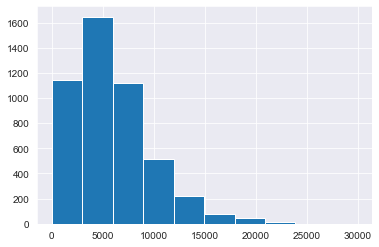

In [66]:
users_distance.distance.hist()

In [67]:
# merge
df = df.merge(users_distance, how='outer', on=['id', 'date'])

In [68]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325,None,2351.59,62.79210,6517.5
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709,None,2332.08,62.67912,7178.6
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801,None,2262.30,62.57307,6090.9
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873,None,2586.76,62.41166,9557.9


In [69]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'distance'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Exercise
The types of exercise the user has performed (N=5416). The names can be in multiple languages, hence we will use the exercise type code.

In [70]:
users_exercise = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "exercise"},
            {"id": user}
        ]},
            {"id": 1, "data.originalStartTime": 1, "data.activityTypeId": 1, "_id": 0}
        )
    ))

    users_exercise = pd.concat([users_exercise, user_data], axis=0)

# split data column (json format) into two columns
users_exercise["date"] = users_exercise["data"].apply(lambda d: d["originalStartTime"])
users_exercise["activityType"] = users_exercise["data"].apply(lambda d: d["activityTypeId"])
users_exercise.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_exercise["date"] = pd.to_datetime(pd.to_datetime(users_exercise["date"], infer_datetime_format=True).dt.date)

In [71]:
users_exercise.head()

,id,date,activityType
0,621e2e8e67b776a24055b564,2021-05-24,90013
1,621e2e8e67b776a24055b564,2021-05-26,90013
2,621e2e8e67b776a24055b564,2021-05-28,90013
3,621e2e8e67b776a24055b564,2021-05-29,90013
4,621e2e8e67b776a24055b564,2021-06-01,90013


In [72]:
users_exercise.dtypes

id                      object
date            datetime64[ns]
activityType             int64
dtype: object

In [73]:
# Get distinct activity types
activity_types = pd.DataFrame(list(
        db.fitbit.find(
            {"type": "exercise"},
            {"id": 1, "data.activityTypeId": 1, "data.activityName": 1, "_id": 0}
        )
    ))
activity_types["activityTypeId"] = activity_types.data.apply(lambda d: d["activityTypeId"])
activity_types["activityName"] = activity_types.data.apply(lambda d: d["activityName"])
activity_types.drop(["data", "id"], inplace=True, axis=1)
activity_types = activity_types.drop_duplicates().reset_index(drop=True)
print(activity_types.head(50))
ACTIVITIES = {
    90013: "Walk",
    15000: "Sport",
    3001: "Aerobic Workout",
    52000: "Yoga/Pilates",
    90024: "Swim",
    90001: "Bike",
    20047: "Elliptical",
    2131: "Weights",
    55001: "Spinning",
    1071: "Bike",
    90009: "Run",
    20049: "Treadmill",
    53000: "Yoga/Pilates",
    55002: "Martial Arts",
    2040: "Circuit Training",
    2065: "Stairclimber",
    3000: "Workout",
    90012: "Hike",
    12339646: "Run",
    12350445: "Walk",
    23418750: "Swim",
    55003: "Bootcamp",
    15430: "Martial Arts",
    20057: "Interval Workout",
    15675: "Tennis",
    61980497: "Workout"
}

    activityTypeId      activityName
0            90013              Walk
1            15000             Sport
2             3001   Aerobic Workout
3            52000      Yoga/Pilates
4            90024              Swim
5            90001              Bike
6            55001          Spinning
7             2131           Weights
8            20047        Elliptical
9            90009               Run
10            1071              Bike
11           20049         Treadmill
12           53000      Yoga/Pilates
13           55002      Martial Arts
14            2040  Circuit Training
15            3000           Workout
16           90012              Hike
17           55003          Bootcamp
18           15430      Martial Arts
19           15675            Tennis
20           20057  Interval Workout


In [74]:
users_exercise["activityType"] = users_exercise["activityType"].apply(lambda a: ACTIVITIES.get(a))
users_exercise.head()

,id,date,activityType
0,621e2e8e67b776a24055b564,2021-05-24,Walk
1,621e2e8e67b776a24055b564,2021-05-26,Walk
2,621e2e8e67b776a24055b564,2021-05-28,Walk
3,621e2e8e67b776a24055b564,2021-05-29,Walk
4,621e2e8e67b776a24055b564,2021-06-01,Walk


In [75]:
users_exercise = users_exercise.groupby(['id', 'date']).activityType.apply(list).reset_index(drop=False)

In [76]:
users_exercise.activityType.value_counts()

[Walk]                              717
[Walk, Walk]                        449
[Walk, Walk, Walk]                  132
[Workout]                            83
[Run]                                64
                                   ... 
[Treadmill, Workout, Walk]            1
[Walk, Treadmill, Walk, Workout]      1
[Elliptical, Workout, Treadmill]      1
[Sport, Yoga/Pilates]                 1
[Interval Workout, Workout]           1
Name: activityType, Length: 221, dtype: int64

In [77]:
users_exercise.activityType = users_exercise.activityType.swifter.apply(lambda l: list(set(l)) if isinstance(l, list) else l)

Pandas Apply:   0%|          | 0/2213 [00:00<?, ?it/s]

In [78]:
users_exercise.activityType.value_counts()

[Walk]                         1374
[Workout]                        90
[Bike]                           85
[Run]                            69
[Sport]                          47
                               ... 
[Weights, Treadmill]              1
[Bootcamp]                        1
[Run, Walk, Workout]              1
[Walk, Treadmill]                 1
[Workout, Interval Workout]       1
Name: activityType, Length: 84, dtype: int64

In [79]:
# merge
df = df.merge(users_exercise, how='outer', on=['id', 'date'])

In [80]:
df.activityType.value_counts()

[Walk]                    1374
[Workout]                   90
[Bike]                      85
[Run]                       69
[Sport]                     47
                          ... 
[Run, Walk, Workout]         1
[Run, Bike]                  1
[Run, Aerobic Workout]       1
[Bike, Elliptical]           1
[Interval Workout]           1
Name: activityType, Length: 84, dtype: int64

In [81]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.astype(str).duplicated(subset=['id','date', 'activityType'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


In [82]:
df.to_pickle("data/temp_df_1.pkl")

### Heart Rate
User’s BPM at 10-sec granularity.

In [83]:
if os.path.exists('data/temp_df_1.pkl'):
    print("Reading DataFrame from pickle...")
    f = open("data/temp_df_1.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    df = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
    print("Reading completed.")

Reading DataFrame from pickle...
Reading completed.


In [84]:
if os.path.exists('data/users_hr_daily.pkl'):
    print("Reading daily data from pickle...")
    f = open("data/users_hr_daily.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_hr = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
    print("Reading completed.")
elif os.path.exists('data/users_hr.pkl'):
    print("Reading raw data from pickle...")
    f = open("data/users_hr.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_hr = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
    print("Reading completed.")

    users_hr.bpm = users_hr.bpm.astype(float)
    users_hr = users_hr.groupby(['id', 'date']).mean()
    users_hr.reset_index(drop=False, inplace=True)
else:
    warnings.warn("\nTo read and aggregate heart rate data from MongoDB you need to ensure index existence for both query (type, id) and projection (data.dateTime, data.value.bpm) fields (compound index of four fields)...\n")
    rows = 0
    users_hr = pd.DataFrame(columns=["id", "date", "bpm"])
    for user in tqdm(users):
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"id": user},
                {"type": "heart_rate"}
            ]},
                {"id": 1, "data.dateTime": 1, "data.value.bpm": 1, "_id": 0}
            )
        ))

        # split data column (json format) into two columns
        # user_data.reset_index(drop=True, inplace=True)
        user_data["date"] = user_data["data"].swifter.apply(lambda d: d["dateTime"])
        user_data["bpm"] = user_data["data"].swifter.apply(lambda d: d["value"].get("bpm"))
        user_data.drop(["data"], inplace=True, axis=1)
        # convert timestamp date object and then to datetime64[ns]
        user_data["date"] = pd.to_datetime(pd.to_datetime(user_data["date"], infer_datetime_format="%Y-%m-%dT%H:%M:%S").dt.date, infer_datetime_format=True)
        # Additional code for counting heart rate instances
        # temp1 = user_data[(user_data['date'] >= "2021-05-24") & (user_data['date'] <= "2021-07-26")]  #Round1
        # temp2 = user_data[(user_data['date'] >= "2021-11-15") & (user_data['date'] <= "2022-01-17")]  #Round2
        # user_data = pd.concat([temp1, temp2])
        # rows += user_data.shape[0]
        # print("Updated rows: {}".format(rows))

        # group by date and then take the average
        user_data.bpm = user_data.bpm.astype(float)
        user_data = user_data.groupby(['id', 'date']).mean()
        user_data.reset_index(drop=False, inplace=True)

        users_hr = pd.concat([users_hr, user_data], axis=0)

    users_hr.to_pickle('data/users_hr_daily.pkl')
    # print("Final rows: {}".format(rows))

C:\Users\Sofia\AppData\Local\Temp\ipykernel_13076\1327747644.py:28: UserWarning: 
To read and aggregate heart rate data from MongoDB you need to ensure index existence for both query (type, id) and projection (data.dateTime, data.value.bpm) fields (compound index of four fields)...

  warnings.warn("\nTo read and aggregate heart rate data from MongoDB you need to ensure index existence for both query (type, id) and projection (data.dateTime, data.value.bpm) fields (compound index of four fields)...\n")
  0%|          | 0/71 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/833645 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/833645 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:15<18:36, 15.95s/it]

Pandas Apply:   0%|          | 0/996480 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/996480 [00:00<?, ?it/s]

  3%|▎         | 2/71 [00:34<20:22, 17.72s/it]

Pandas Apply:   0%|          | 0/894222 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/894222 [00:00<?, ?it/s]

  4%|▍         | 3/71 [00:49<18:26, 16.27s/it]

Pandas Apply:   0%|          | 0/76106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/76106 [00:00<?, ?it/s]

  6%|▌         | 4/71 [00:50<11:33, 10.36s/it]

Pandas Apply:   0%|          | 0/855660 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/855660 [00:00<?, ?it/s]

  7%|▋         | 5/71 [01:06<13:22, 12.15s/it]

Pandas Apply:   0%|          | 0/842208 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/842208 [00:00<?, ?it/s]

  8%|▊         | 6/71 [01:21<14:30, 13.39s/it]

Pandas Apply:   0%|          | 0/665516 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/665516 [00:00<?, ?it/s]

 10%|▉         | 7/71 [01:33<13:48, 12.94s/it]

Pandas Apply:   0%|          | 0/274523 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/274523 [00:00<?, ?it/s]

 11%|█▏        | 8/71 [01:38<10:44, 10.23s/it]

Pandas Apply:   0%|          | 0/598217 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/598217 [00:00<?, ?it/s]

 13%|█▎        | 9/71 [01:47<10:11,  9.86s/it]

Pandas Apply:   0%|          | 0/709259 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/709259 [00:00<?, ?it/s]

 14%|█▍        | 10/71 [02:00<10:59, 10.80s/it]

Pandas Apply:   0%|          | 0/935373 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/935373 [00:00<?, ?it/s]

 15%|█▌        | 11/71 [02:16<12:21, 12.36s/it]

Pandas Apply:   0%|          | 0/760730 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/760730 [00:00<?, ?it/s]

 17%|█▋        | 12/71 [02:28<12:15, 12.47s/it]

Pandas Apply:   0%|          | 0/764621 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/764621 [00:00<?, ?it/s]

 18%|█▊        | 13/71 [02:41<11:57, 12.36s/it]

Pandas Apply:   0%|          | 0/705009 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/705009 [00:00<?, ?it/s]

 20%|█▉        | 14/71 [02:53<11:42, 12.33s/it]

Pandas Apply:   0%|          | 0/411014 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/411014 [00:00<?, ?it/s]

 21%|██        | 15/71 [02:59<09:55, 10.63s/it]

Pandas Apply:   0%|          | 0/262245 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/262245 [00:00<?, ?it/s]

 23%|██▎       | 16/71 [03:04<07:59,  8.72s/it]

Pandas Apply:   0%|          | 0/1386875 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1386875 [00:00<?, ?it/s]

 24%|██▍       | 17/71 [03:26<11:38, 12.94s/it]

Pandas Apply:   0%|          | 0/288590 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/288590 [00:00<?, ?it/s]

 25%|██▌       | 18/71 [03:33<09:38, 10.91s/it]

Pandas Apply:   0%|          | 0/751941 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/751941 [00:00<?, ?it/s]

 27%|██▋       | 19/71 [03:45<09:41, 11.19s/it]

Pandas Apply:   0%|          | 0/681332 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/681332 [00:00<?, ?it/s]

 28%|██▊       | 20/71 [03:57<09:47, 11.52s/it]

Pandas Apply:   0%|          | 0/715218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/715218 [00:00<?, ?it/s]

 30%|██▉       | 21/71 [04:08<09:30, 11.41s/it]

Pandas Apply:   0%|          | 0/4349 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4349 [00:00<?, ?it/s]

 31%|███       | 22/71 [04:08<06:37,  8.10s/it]

Pandas Apply:   0%|          | 0/309998 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/309998 [00:00<?, ?it/s]

 32%|███▏      | 23/71 [04:13<05:45,  7.20s/it]

Pandas Apply:   0%|          | 0/785675 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/785675 [00:00<?, ?it/s]

 34%|███▍      | 24/71 [04:27<07:14,  9.23s/it]

Pandas Apply:   0%|          | 0/891691 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/891691 [00:00<?, ?it/s]

 35%|███▌      | 25/71 [04:41<08:10, 10.66s/it]

Pandas Apply:   0%|          | 0/886265 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/886265 [00:00<?, ?it/s]

 37%|███▋      | 26/71 [04:57<09:00, 12.02s/it]

Pandas Apply:   0%|          | 0/772043 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/772043 [00:00<?, ?it/s]

 38%|███▊      | 27/71 [05:09<08:58, 12.23s/it]

Pandas Apply:   0%|          | 0/724449 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/724449 [00:00<?, ?it/s]

 39%|███▉      | 28/71 [05:22<08:57, 12.51s/it]

Pandas Apply:   0%|          | 0/550170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/550170 [00:00<?, ?it/s]

 41%|████      | 29/71 [05:31<07:56, 11.33s/it]

Pandas Apply:   0%|          | 0/720193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/720193 [00:00<?, ?it/s]

 42%|████▏     | 30/71 [05:44<08:01, 11.74s/it]

Pandas Apply:   0%|          | 0/798873 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/798873 [00:00<?, ?it/s]

 44%|████▎     | 31/71 [05:56<07:56, 11.91s/it]

Pandas Apply:   0%|          | 0/827437 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/827437 [00:00<?, ?it/s]

 45%|████▌     | 32/71 [06:11<08:17, 12.75s/it]

Pandas Apply:   0%|          | 0/109708 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109708 [00:00<?, ?it/s]

 46%|████▋     | 33/71 [06:13<06:04,  9.58s/it]

Pandas Apply:   0%|          | 0/767009 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/767009 [00:00<?, ?it/s]

 48%|████▊     | 34/71 [06:25<06:21, 10.31s/it]

Pandas Apply:   0%|          | 0/700291 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/700291 [00:00<?, ?it/s]

 49%|████▉     | 35/71 [06:37<06:34, 10.95s/it]

Pandas Apply:   0%|          | 0/260723 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/260723 [00:00<?, ?it/s]

 51%|█████     | 36/71 [06:42<05:15,  9.01s/it]

Pandas Apply:   0%|          | 0/233003 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/233003 [00:00<?, ?it/s]

 52%|█████▏    | 37/71 [06:46<04:12,  7.43s/it]

Pandas Apply:   0%|          | 0/1105643 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1105643 [00:00<?, ?it/s]

 54%|█████▎    | 38/71 [07:05<06:00, 10.93s/it]

Pandas Apply:   0%|          | 0/591970 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/591970 [00:00<?, ?it/s]

 55%|█████▍    | 39/71 [07:14<05:37, 10.54s/it]

Pandas Apply:   0%|          | 0/396503 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/396503 [00:00<?, ?it/s]

 56%|█████▋    | 40/71 [07:21<04:49,  9.34s/it]

Pandas Apply:   0%|          | 0/41974 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/41974 [00:00<?, ?it/s]

 58%|█████▊    | 41/71 [07:22<03:24,  6.83s/it]

Pandas Apply:   0%|          | 0/1022960 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1022960 [00:00<?, ?it/s]

 59%|█████▉    | 42/71 [07:40<04:56, 10.22s/it]

Pandas Apply:   0%|          | 0/778071 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/778071 [00:00<?, ?it/s]

 61%|██████    | 43/71 [07:53<05:11, 11.11s/it]

Pandas Apply:   0%|          | 0/976521 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/976521 [00:00<?, ?it/s]

 62%|██████▏   | 44/71 [08:12<05:59, 13.33s/it]

Pandas Apply:   0%|          | 0/699357 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/699357 [00:00<?, ?it/s]

 63%|██████▎   | 45/71 [08:25<05:47, 13.38s/it]

Pandas Apply:   0%|          | 0/786082 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/786082 [00:00<?, ?it/s]

 65%|██████▍   | 46/71 [08:38<05:32, 13.31s/it]

Pandas Apply:   0%|          | 0/967338 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/967338 [00:00<?, ?it/s]

 66%|██████▌   | 47/71 [08:58<06:02, 15.09s/it]

Pandas Apply:   0%|          | 0/765383 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/765383 [00:00<?, ?it/s]

 68%|██████▊   | 48/71 [09:11<05:34, 14.56s/it]

Pandas Apply:   0%|          | 0/359728 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/359728 [00:00<?, ?it/s]

 69%|██████▉   | 49/71 [09:18<04:30, 12.29s/it]

Pandas Apply:   0%|          | 0/862356 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/862356 [00:00<?, ?it/s]

 70%|███████   | 50/71 [09:35<04:45, 13.60s/it]

Pandas Apply:   0%|          | 0/1239388 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1239388 [00:00<?, ?it/s]

 72%|███████▏  | 51/71 [09:58<05:29, 16.47s/it]

Pandas Apply:   0%|          | 0/300940 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/300940 [00:00<?, ?it/s]

 73%|███████▎  | 52/71 [10:03<04:11, 13.25s/it]

Pandas Apply:   0%|          | 0/567224 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/567224 [00:00<?, ?it/s]

 75%|███████▍  | 53/71 [10:14<03:42, 12.35s/it]

Pandas Apply:   0%|          | 0/2607755 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2607755 [00:00<?, ?it/s]

 76%|███████▌  | 54/71 [11:12<07:26, 26.26s/it]

Pandas Apply:   0%|          | 0/394001 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/394001 [00:00<?, ?it/s]

 77%|███████▋  | 55/71 [11:20<05:28, 20.54s/it]

Pandas Apply:   0%|          | 0/352926 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/352926 [00:00<?, ?it/s]

 79%|███████▉  | 56/71 [11:26<04:04, 16.33s/it]

Pandas Apply:   0%|          | 0/127632 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127632 [00:00<?, ?it/s]

 80%|████████  | 57/71 [11:29<02:50, 12.16s/it]

Pandas Apply:   0%|          | 0/198733 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198733 [00:00<?, ?it/s]

 82%|████████▏ | 58/71 [11:32<02:04,  9.60s/it]

Pandas Apply:   0%|          | 0/700231 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/700231 [00:00<?, ?it/s]

 83%|████████▎ | 59/71 [11:45<02:06, 10.52s/it]

Pandas Apply:   0%|          | 0/1093301 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1093301 [00:00<?, ?it/s]

 85%|████████▍ | 60/71 [12:07<02:35, 14.10s/it]

Pandas Apply:   0%|          | 0/836590 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/836590 [00:00<?, ?it/s]

 86%|████████▌ | 61/71 [12:21<02:20, 14.09s/it]

Pandas Apply:   0%|          | 0/678029 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/678029 [00:00<?, ?it/s]

 87%|████████▋ | 62/71 [12:35<02:04, 13.83s/it]

Pandas Apply:   0%|          | 0/665931 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/665931 [00:00<?, ?it/s]

 89%|████████▊ | 63/71 [12:46<01:44, 13.01s/it]

Pandas Apply:   0%|          | 0/804271 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/804271 [00:00<?, ?it/s]

 90%|█████████ | 64/71 [13:01<01:35, 13.60s/it]

Pandas Apply:   0%|          | 0/1784290 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1784290 [00:00<?, ?it/s]

 92%|█████████▏| 65/71 [13:32<01:53, 18.90s/it]

Pandas Apply:   0%|          | 0/189893 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189893 [00:00<?, ?it/s]

 93%|█████████▎| 66/71 [13:36<01:12, 14.44s/it]

Pandas Apply:   0%|          | 0/604998 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/604998 [00:00<?, ?it/s]

 94%|█████████▍| 67/71 [13:46<00:52, 13.15s/it]

Pandas Apply:   0%|          | 0/666654 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/666654 [00:00<?, ?it/s]

 96%|█████████▌| 68/71 [13:59<00:39, 13.07s/it]

Pandas Apply:   0%|          | 0/707328 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/707328 [00:00<?, ?it/s]

 97%|█████████▋| 69/71 [14:11<00:25, 12.75s/it]

Pandas Apply:   0%|          | 0/271642 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/271642 [00:00<?, ?it/s]

 99%|█████████▊| 70/71 [14:16<00:10, 10.49s/it]

Pandas Apply:   0%|          | 0/823736 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/823736 [00:00<?, ?it/s]

100%|██████████| 71/71 [14:31<00:00, 12.28s/it]


In [85]:
users_hr.head(20)

,id,date,bpm
0,621e2e8e67b776a24055b564,2021-05-24 00:00:00,71.701565
1,621e2e8e67b776a24055b564,2021-05-25 00:00:00,70.5793
2,621e2e8e67b776a24055b564,2021-05-26 00:00:00,71.842573
3,621e2e8e67b776a24055b564,2021-05-27 00:00:00,71.725477
4,621e2e8e67b776a24055b564,2021-05-28 00:00:00,74.401028
5,621e2e8e67b776a24055b564,2021-05-29 00:00:00,83.73977
6,621e2e8e67b776a24055b564,2021-05-30 00:00:00,68.475259
7,621e2e8e67b776a24055b564,2021-05-31 00:00:00,69.314358
8,621e2e8e67b776a24055b564,2021-06-01 00:00:00,69.309896
9,621e2e8e67b776a24055b564,2021-06-02 00:00:00,70.85414


In [86]:
# convert timestamp date object and then to datetime64[ns]
users_hr["date"] = pd.to_datetime(pd.to_datetime(users_hr["date"], format="%Y/%m/%d  %H:%M:%S").dt.date, format="%Y/%m/%d")

In [87]:
users_hr.head()

,id,date,bpm
0,621e2e8e67b776a24055b564,2021-05-24,71.701565
1,621e2e8e67b776a24055b564,2021-05-25,70.5793
2,621e2e8e67b776a24055b564,2021-05-26,71.842573
3,621e2e8e67b776a24055b564,2021-05-27,71.725477
4,621e2e8e67b776a24055b564,2021-05-28,74.401028


In [88]:
# merge
df = df.merge(users_hr, how='outer', on=['id', 'date'])

In [89]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325,None,2351.59,62.79210,6517.5,[Walk],71.701565
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709,None,2332.08,62.67912,7178.6,[Walk],70.5793
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801,None,2262.30,62.57307,6090.9,[Walk],71.842573
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873,None,2586.76,62.41166,9557.9,[Walk],74.401028


In [90]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'bpm'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Lightly Active Minutes
Light activity minutes (N=12086).

In [91]:
users_active_minutes = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "lightly_active_minutes"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_active_minutes = pd.concat([users_active_minutes, user_data], axis=0)

# split data column (json format) into two columns
users_active_minutes["date"] = users_active_minutes["data"].apply(lambda d: d["dateTime"])
users_active_minutes["lightly_active_minutes"] = users_active_minutes["data"].apply(lambda d: d["value"])
users_active_minutes.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_active_minutes["date"] = pd.to_datetime(pd.to_datetime(users_active_minutes["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [92]:
users_active_minutes.head()

,id,date,lightly_active_minutes
0,621e2e8e67b776a24055b564,2021-05-26,112
1,621e2e8e67b776a24055b564,2021-05-29,305
2,621e2e8e67b776a24055b564,2021-06-01,106
3,621e2e8e67b776a24055b564,2021-06-04,117
4,621e2e8e67b776a24055b564,2021-06-07,123


In [93]:
# merge
df = df.merge(users_active_minutes, how='outer', on=['id', 'date'])

In [94]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325,None,2351.59,62.79210,6517.5,[Walk],71.701565,149
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709,None,2332.08,62.67912,7178.6,[Walk],70.5793,132
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801,None,2262.30,62.57307,6090.9,[Walk],71.842573,112
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873,None,2586.76,62.41166,9557.9,[Walk],74.401028,136
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,0.833333,-2.638646,"[DAILY_FLOORS, DAILY_STEPS, LIFETIME_FLOORS]",3806.02,62.31740,18809.0,[Walk],83.73977,305
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,0.833333,-1.090828,None,1968.24,62.19706,2799.7,NaN,68.475259,113
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,0.900000,-2.577960,None,2300.02,62.10474,6822.5,[Walk],69.314358,149
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,0.900000,-2.179900,None,2227.17,62.06227,6215.8,[Walk],69.309896,106
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,0.800000,-2.090289,None,2262.88,62.04591,6113.9,[Walk],70.85414,105


In [95]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'lightly_active_minutes'], keep=False)].shape[0]))

Duplicates based on ID and Date: 240
Duplicates based on ID and Date and Value: 234


In [96]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes
1456,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,None,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,0
1457,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,None,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78
1476,621e301e67b776a240608a72,2021-09-09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,None,1302.0,44.968210000000006,15.1,nan,85.9326923076923,0
1477,621e301e67b776a240608a72,2021-09-09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,None,1302.0,44.968210000000006,15.1,nan,85.9326923076923,3
1488,621e301e67b776a240608a72,2021-09-15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,None,1297.49,44.675360000000005,5.5,nan,69.17117117117117,0
1489,621e301e67b776a240608a72,2021-09-15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,None,1297.49,44.675360000000005,5.5,nan,69.17117117117117,1


In [97]:
# Keep max to avoid 0 values when non-zero values exist for the same date and user ID
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7231
Size after duplicate elimination: 7111


In [98]:
df.head(300)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,621e2ef567b776a24099f889,2021-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843.20,NaN,NaN,NaN,NaN,0
296,621e2ef567b776a24099f889,2021-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843.20,NaN,NaN,NaN,NaN,0
297,621e2ef567b776a24099f889,2021-11-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843.20,NaN,NaN,NaN,NaN,0
298,621e2ef567b776a24099f889,2021-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843.20,NaN,NaN,NaN,NaN,0


### Moderately Active Minutes
Moderate activity minutes (N=12086).

In [99]:
users_active_minutes = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "moderately_active_minutes"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_active_minutes = pd.concat([users_active_minutes, user_data], axis=0)

# split data column (json format) into two columns
users_active_minutes["date"] = users_active_minutes["data"].apply(lambda d: d["dateTime"])
users_active_minutes["moderately_active_minutes"] = users_active_minutes["data"].apply(lambda d: d["value"])
users_active_minutes.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_active_minutes["date"] = pd.to_datetime(pd.to_datetime(users_active_minutes["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [100]:
users_active_minutes.head()

,id,date,moderately_active_minutes
0,621e2e8e67b776a24055b564,2021-05-26,27
1,621e2e8e67b776a24055b564,2021-05-29,128
2,621e2e8e67b776a24055b564,2021-06-01,30
3,621e2e8e67b776a24055b564,2021-06-04,51
4,621e2e8e67b776a24055b564,2021-06-07,24


In [101]:
# merge
df = df.merge(users_active_minutes, how='outer', on=['id', 'date'])

In [102]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,0.866667,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,0.866667,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,0.866667,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,0.833333,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,0.866667,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42


In [103]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'moderately_active_minutes'], keep=False)].shape[0]))

Duplicates based on ID and Date: 240
Duplicates based on ID and Date and Value: 238


In [104]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes
1542,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78,0
1543,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78,18


In [105]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7231
Size after duplicate elimination: 7111


### Very Active Minutes
Very activity minutes (N=12086).

In [106]:
users_active_minutes = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "very_active_minutes"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_active_minutes = pd.concat([users_active_minutes, user_data], axis=0)

# split data column (json format) into two columns
users_active_minutes["date"] = users_active_minutes["data"].apply(lambda d: d["dateTime"])
users_active_minutes["very_active_minutes"] = users_active_minutes["data"].apply(lambda d: d["value"])
users_active_minutes.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_active_minutes["date"] = pd.to_datetime(pd.to_datetime(users_active_minutes["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [107]:
users_active_minutes.head()

,id,date,very_active_minutes
0,621e2e8e67b776a24055b564,2021-05-26,31
1,621e2e8e67b776a24055b564,2021-05-30,0
2,621e2e8e67b776a24055b564,2021-06-03,36
3,621e2e8e67b776a24055b564,2021-06-07,34
4,621e2e8e67b776a24055b564,2021-06-11,45


In [108]:
# merge
df = df.merge(users_active_minutes, how='outer', on=['id', 'date'])

In [109]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24,33
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25,31
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27,31
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21,37
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42,54


In [110]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'very_active_minutes'], keep=False)].shape[0]))

Duplicates based on ID and Date: 240
Duplicates based on ID and Date and Value: 238


In [111]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7231
Size after duplicate elimination: 7111


### Sedentary Minutes
Sedentary minutes (N=12086).

In [112]:
users_active_minutes = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "sedentary_minutes"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_active_minutes = pd.concat([users_active_minutes, user_data], axis=0)

# split data column (json format) into two columns
users_active_minutes["date"] = users_active_minutes["data"].apply(lambda d: d["dateTime"])
users_active_minutes["sedentary_minutes"] = users_active_minutes["data"].apply(lambda d: d["value"])
users_active_minutes.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_active_minutes["date"] = pd.to_datetime(pd.to_datetime(users_active_minutes["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [113]:
users_active_minutes.head()

,id,date,sedentary_minutes
0,621e2e8e67b776a24055b564,2021-05-24,713
1,621e2e8e67b776a24055b564,2021-05-27,622
2,621e2e8e67b776a24055b564,2021-05-30,763
3,621e2e8e67b776a24055b564,2021-06-02,700
4,621e2e8e67b776a24055b564,2021-06-05,735


In [114]:
# merge
df = df.merge(users_active_minutes, how='outer', on=['id', 'date'])

In [115]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24,33,713
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25,31,704
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27,31,710
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21,37,622
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42,54,647


In [116]:
df.to_pickle('data/temp_df_2.pkl')

In [117]:
df = pd.read_pickle('data/temp_df_2.pkl')

In [118]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24,33,713
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25,31,704
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27,31,710
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21,37,622
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42,54,647
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,...,"[DAILY_FLOORS, DAILY_STEPS, LIFETIME_FLOORS]",3806.02,62.31740,18809.0,[Walk],83.739770,305,128,98,371
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,...,NaN,1968.24,62.19706,2799.7,NaN,68.475259,113,9,0,763
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,...,NaN,2300.02,62.10474,6822.5,[Walk],69.314358,149,23,34,655
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,...,NaN,2227.17,62.06227,6215.8,[Walk],69.309896,106,30,29,691
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,...,NaN,2262.88,62.04591,6113.9,[Walk],70.854140,105,22,39,700


In [119]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'sedentary_minutes'], keep=False)].shape[0]))

Duplicates based on ID and Date: 240
Duplicates based on ID and Date and Value: 232


In [120]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes
1538,621e301e67b776a240608a72,2021-08-28,31.0584031414,nan,nan,nan,nan,0.0,0.0,0.0,...,nan,2810.01,46.73335,2128.1,nan,110.09664780148019,27,8,19,954
1539,621e301e67b776a240608a72,2021-08-28,31.0584031414,nan,nan,nan,nan,0.0,0.0,0.0,...,nan,2810.01,46.73335,2128.1,nan,110.09664780148019,27,8,19,1192
1542,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78,18,21,1440
1543,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78,18,21,1323
1562,621e301e67b776a240608a72,2021-09-09,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,1302.0,44.968210000000006,15.1,nan,85.9326923076923,3,0,0,1440
1563,621e301e67b776a240608a72,2021-09-09,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,1302.0,44.968210000000006,15.1,nan,85.9326923076923,3,0,0,1437
1574,621e301e67b776a240608a72,2021-09-15,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,1297.49,44.675360000000005,5.5,nan,69.17117117117117,1,0,0,1440
1575,621e301e67b776a240608a72,2021-09-15,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,1297.49,44.675360000000005,5.5,nan,69.17117117117117,1,0,0,1439


In [121]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7231
Size after duplicate elimination: 7111


### Mindfulness Sessions
These data can help us understand if the user conducted an EDA session voluntarily (N=27785).

In [122]:
def try_parsing_date(text):
    for fmt in ('%Y-%m-%dT%H:%M:%S%z', '%Y-%m-%dT%H:%M%z'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found for {}'.format(text))

In [123]:
users_mindfulness = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "mindfulness_sessions"},
            {"id": user}
        ]},
            {"id": 1, "data.start_date_time": 1, "data.session_type": 1, "_id": 0}
        )
    ))

    users_mindfulness = pd.concat([users_mindfulness, user_data], axis=0)

# split data column (json format) into two columns
users_mindfulness["date"] = users_mindfulness["data"].apply(lambda d: d["start_date_time"])
users_mindfulness["activityType"] = users_mindfulness["data"].apply(lambda d: d["session_type"])
users_mindfulness.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
# users_mindfulness["date"] = pd.to_datetime(users_mindfulness["date"], format='%Y-%m-%dT%H:%M:%S%z')
users_mindfulness["date"] = pd.to_datetime(pd.to_datetime(users_mindfulness["date"], infer_datetime_format=True).dt.date)

users_mindfulness["mindfulness_session"] = True  # instead of storing the session type, only store if user engaged in session
users_mindfulness.drop(['activityType'], axis=1, inplace=True)
users_mindfulness = users_mindfulness.drop_duplicates()

In [124]:
users_mindfulness.head()

,id,date,mindfulness_session
0,621e2f1b67b776a240b3d87c,2022-01-01,True
1,621e2f1b67b776a240b3d87c,2021-12-16,True
2,621e2f1b67b776a240b3d87c,2021-12-15,True
3,621e2f1b67b776a240b3d87c,2021-12-02,True
4,621e2f1b67b776a240b3d87c,2021-11-07,True


In [125]:
# merge
df = df.merge(users_mindfulness, how='outer', on=['id', 'date'])
df.mindfulness_session.fillna('False', inplace=True)

In [126]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,mindfulness_session
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,2351.59,62.79210,6517.5,[Walk],71.701565,149,24,33,713,False
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,2332.08,62.67912,7178.6,[Walk],70.579300,132,25,31,704,False
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,2262.30,62.57307,6090.9,[Walk],71.842573,112,27,31,710,False
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,2325.10,62.47493,6653.1,[Walk],71.725477,133,21,37,622,False
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,2586.76,62.41166,9557.9,[Walk],74.401028,136,42,54,647,False
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,...,3806.02,62.31740,18809.0,[Walk],83.739770,305,128,98,371,False
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,...,1968.24,62.19706,2799.7,NaN,68.475259,113,9,0,763,False
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,...,2300.02,62.10474,6822.5,[Walk],69.314358,149,23,34,655,False
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,...,2227.17,62.06227,6215.8,[Walk],69.309896,106,30,29,691,False
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,...,2262.88,62.04591,6113.9,[Walk],70.854140,105,22,39,700,False


In [127]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'mindfulness_session'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Mindfulness EDA Data Sessions
These entries contain the skin conductance level, which we can get on average for a day (i.e., as an indication of stress).

In [128]:
users_eda = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "mindfulness_eda_data_sessions"},
            {"id": user}
        ]},
            {"id": 1, "data.timestamp": 1, "data.scl_avg": 1, "_id": 0}
        )
    ))

    users_eda = pd.concat([users_eda, user_data], axis=0)

# split data column (json format) into two columns
users_eda["date"] = users_eda["data"].apply(lambda d: d["timestamp"])
users_eda["scl_avg"] = users_eda["data"].apply(lambda d: d["scl_avg"])
users_eda.drop(["data"], inplace=True, axis=1)

users_eda.reset_index(drop=True, inplace=True)
# convert timestamp date object and then to datetime64[ns]
users_eda["date"] = pd.to_datetime(pd.to_datetime(users_exercise["date"], infer_datetime_format=True).dt.date)
# users_eda["date"] = pd.to_datetime(users_eda["date"].swifter.apply(lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d')), format='%Y-%m-%d')

In [129]:
users_eda.head()

,id,date,scl_avg
0,621e2f1b67b776a240b3d87c,2021-05-24,0.000000
1,621e2f1b67b776a240b3d87c,2021-05-25,0.000000
2,621e2f1b67b776a240b3d87c,2021-05-26,0.000000
3,621e2f1b67b776a240b3d87c,2021-05-27,35.823334
4,621e2f1b67b776a240b3d87c,2021-05-28,32.682442


In [130]:
users_eda.dtypes

id                 object
date       datetime64[ns]
scl_avg           float64
dtype: object

In [131]:
# group by date and then take the average
users_eda = users_eda.groupby(['id', 'date']).mean()
users_eda.reset_index(drop=False, inplace=True)

In [132]:
users_eda.head()

,id,date,scl_avg
0,621e2f1b67b776a240b3d87c,2021-05-24,2.463279
1,621e2f1b67b776a240b3d87c,2021-05-25,3.555977
2,621e2f1b67b776a240b3d87c,2021-05-26,2.555254
3,621e2f1b67b776a240b3d87c,2021-05-27,5.164721
4,621e2f1b67b776a240b3d87c,2021-05-28,4.226912


In [133]:
# merge
df = df.merge(users_eda, how='outer', on=['id', 'date'])

In [134]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,mindfulness_session,scl_avg
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,62.79210,6517.5,[Walk],71.701565,149,24,33,713,False,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,62.67912,7178.6,[Walk],70.579300,132,25,31,704,False,NaN
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,62.57307,6090.9,[Walk],71.842573,112,27,31,710,False,NaN
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,62.47493,6653.1,[Walk],71.725477,133,21,37,622,False,NaN
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,62.41166,9557.9,[Walk],74.401028,136,42,54,647,False,NaN
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,...,62.31740,18809.0,[Walk],83.739770,305,128,98,371,False,NaN
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,...,62.19706,2799.7,NaN,68.475259,113,9,0,763,False,NaN
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,...,62.10474,6822.5,[Walk],69.314358,149,23,34,655,False,NaN
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,...,62.06227,6215.8,[Walk],69.309896,106,30,29,691,False,NaN
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,...,62.04591,6113.9,[Walk],70.854140,105,22,39,700,False,NaN


In [135]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'scl_avg'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Resting Heart Rate
A normal resting heart rate for adults ranges from 60 to 100 beats per minute. Generally, a lower heart rate at rest implies more efficient heart function and better cardiovascular fitness.

In [136]:
users_rhr = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "resting_heart_rate"},
            {"id": user}
        ]},
            {"id": 1, "data.value.date": 1, "data.value.value": 1, "_id": 0}
        )
    ))

    users_rhr = pd.concat([users_rhr, user_data], axis=0)

# split data column (json format) into two columns
users_rhr["date"] = users_rhr["data"].apply(lambda d: d["value"].get("date"))
users_rhr["resting_hr"] = users_rhr["data"].apply(lambda d: d["value"].get("value"))
users_rhr.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_rhr["date"] = pd.to_datetime(users_rhr["date"], format="%m/%d/%y")

In [137]:
users_rhr.head(50)

,id,date,resting_hr
0,621e2e8e67b776a24055b564,2021-05-25,62.121476
1,621e2e8e67b776a24055b564,2021-05-28,61.965409
2,621e2e8e67b776a24055b564,2021-05-31,63.121265
3,621e2e8e67b776a24055b564,2021-06-07,59.557202
4,621e2e8e67b776a24055b564,2021-06-10,59.877669
5,621e2e8e67b776a24055b564,2021-06-13,59.921622
6,621e2e8e67b776a24055b564,2021-06-16,61.495373
7,621e2e8e67b776a24055b564,2021-06-19,59.549614
8,621e2e8e67b776a24055b564,2021-06-22,57.934354
9,621e2e8e67b776a24055b564,2021-06-25,57.747993


In [138]:
users_rhr = users_rhr[users_rhr.resting_hr != 0.0]

In [139]:
users_rhr.head(20)

,id,date,resting_hr
0,621e2e8e67b776a24055b564,2021-05-25,62.121476
1,621e2e8e67b776a24055b564,2021-05-28,61.965409
2,621e2e8e67b776a24055b564,2021-05-31,63.121265
3,621e2e8e67b776a24055b564,2021-06-07,59.557202
4,621e2e8e67b776a24055b564,2021-06-10,59.877669
5,621e2e8e67b776a24055b564,2021-06-13,59.921622
6,621e2e8e67b776a24055b564,2021-06-16,61.495373
7,621e2e8e67b776a24055b564,2021-06-19,59.549614
8,621e2e8e67b776a24055b564,2021-06-22,57.934354
9,621e2e8e67b776a24055b564,2021-06-25,57.747993


In [140]:
# merge
df = df.merge(users_rhr, how='outer', on=['id', 'date'])

In [141]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,mindfulness_session,scl_avg,resting_hr
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,6517.5,[Walk],71.701565,149,24,33,713,False,NaN,62.073070
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,7178.6,[Walk],70.579300,132,25,31,704,False,NaN,62.121476
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,6090.9,[Walk],71.842573,112,27,31,710,False,NaN,62.263999
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,6653.1,[Walk],71.725477,133,21,37,622,False,NaN,62.368900
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,9557.9,[Walk],74.401028,136,42,54,647,False,NaN,61.965409
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,...,18809.0,[Walk],83.739770,305,128,98,371,False,NaN,62.671748
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,...,2799.7,NaN,68.475259,113,9,0,763,False,NaN,63.359720
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,...,6822.5,[Walk],69.314358,149,23,34,655,False,NaN,63.121265
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,...,6215.8,[Walk],69.309896,106,30,29,691,False,NaN,62.419622
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,...,6113.9,[Walk],70.854140,105,22,39,700,False,NaN,62.038037


In [142]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'resting_hr'], keep=False)].shape[0]))

Duplicates based on ID and Date: 102
Duplicates based on ID and Date and Value: 102


In [143]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7404
Size after duplicate elimination: 7353


### Sleep
Details about a user’s sleep IF they wore their Fitbit to bed.

In [144]:
def try_sleep_minutes(d, type):
    try:
        ratio = d["levels"].get("summary").get(type).get("minutes")/d["levels"].get("summary").get(type).get("thirtyDayAvgMinutes")
    except AttributeError:
        ratio = np.nan
    except ZeroDivisionError:
        ratio = np.nan

    return ratio

In [145]:
# todo Test if each user has one main sleep session per day
# Problem with {type:"sleep", id: ObjectId('621e301e67b776a240608a72'), "data.dateOfSleep": "2021-06-23"}

In [146]:
users_sleep = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "sleep"},
            {"id": user},
            {"data.mainSleep": True}
        ]},
            {"id": 1, "data.dateOfSleep": 1, "data.duration": 1, "data.minutesToFallAsleep": 1, "data.minutesAsleep": 1, "data.minutesAwake": 1, "data.minutesAfterWakeup": 1, "data.efficiency": 1, "data.levels.summary.deep.minutes": 1, "data.levels.summary.deep.thirtyDayAvgMinutes": 1, "data.levels.summary.wake.minutes": 1, "data.levels.summary.wake.thirtyDayAvgMinutes": 1, "data.levels.summary.light.minutes": 1, "data.levels.summary.light.thirtyDayAvgMinutes": 1, "data.levels.summary.rem.minutes": 1, "data.levels.summary.rem.thirtyDayAvgMinutes": 1, "_id": 0}
        )
    ))

    users_sleep = pd.concat([users_sleep, user_data], axis=0)

# split data column (json format) into two columns
users_sleep["date"] = users_sleep["data"].apply(lambda d: d["dateOfSleep"])
users_sleep["sleep_duration"] = users_sleep["data"].apply(lambda d: d["duration"])
users_sleep["minutesToFallAsleep"] = users_sleep["data"].apply(lambda d: d["minutesToFallAsleep"])
users_sleep["minutesAsleep"] = users_sleep["data"].apply(lambda d: d["minutesAsleep"])
users_sleep["minutesAwake"] = users_sleep["data"].apply(lambda d: d["minutesAwake"])
users_sleep["minutesAfterWakeup"] = users_sleep["data"].apply(lambda d: d["minutesAfterWakeup"])
users_sleep["sleep_efficiency"] = users_sleep["data"].apply(lambda d: d["efficiency"])
users_sleep["sleep_deep_ratio"] = users_sleep["data"].apply(lambda d: try_sleep_minutes(d, "deep"))
users_sleep["sleep_wake_ratio"] = users_sleep["data"].apply(lambda d: try_sleep_minutes(d, "wake"))
users_sleep["sleep_light_ratio"] = users_sleep["data"].apply(lambda d: try_sleep_minutes(d, "light"))
users_sleep["sleep_rem_ratio"] = users_sleep["data"].apply(lambda d: try_sleep_minutes(d, "rem"))
users_sleep.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_sleep["date"] = pd.to_datetime(users_sleep["date"], infer_datetime_format=True)

In [147]:
users_sleep.head(50)

,id,date,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio
0,621e2e8e67b776a24055b564,2021-06-02,34440000,0,479,95,0,96,1.423077,1.233766,0.935252,1.186813
1,621e2e8e67b776a24055b564,2021-05-30,33300000,0,485,70,0,94,0.974026,0.909091,1.120438,1.157303
2,621e2e8e67b776a24055b564,2021-05-27,37620000,0,540,87,0,93,1.128205,1.129870,1.191729,1.588235
3,621e2e8e67b776a24055b564,2021-05-24,31260000,0,445,76,0,93,1.243243,0.987013,0.921642,1.341772
4,621e2e8e67b776a24055b564,2021-07-03,33240000,0,455,99,0,94,0.705128,1.137931,1.156997,0.648936
5,621e2e8e67b776a24055b564,2021-06-30,34080000,0,466,102,5,92,0.759494,1.200000,1.124138,0.833333
6,621e2e8e67b776a24055b564,2021-06-27,34620000,0,471,106,0,90,0.700000,1.247059,1.147766,0.843750
7,621e2e8e67b776a24055b564,2021-06-24,34260000,0,484,87,3,94,1.602564,1.011628,0.894558,1.021277
8,621e2e8e67b776a24055b564,2021-06-21,32220000,0,470,67,0,93,0.921053,0.770115,1.080537,0.812500
9,621e2e8e67b776a24055b564,2021-06-18,35040000,0,492,92,0,91,1.250000,1.095238,0.979522,1.185567


In [148]:
# merge
df = df.merge(users_sleep, how='outer', on=['id', 'date'])

In [149]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,31260000.0,0.0,445.0,76.0,0.0,93.0,1.243243,0.987013,0.921642,1.341772
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,32880000.0,0.0,460.0,88.0,0.0,94.0,1.466667,1.142857,0.947566,1.197531
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,33600000.0,0.0,493.0,67.0,0.0,96.0,1.116883,0.858974,1.015038,1.670732
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,37620000.0,0.0,540.0,87.0,0.0,93.0,1.128205,1.129870,1.191729,1.588235
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,33660000.0,0.0,493.0,68.0,0.0,94.0,0.910256,0.871795,1.211896,1.090909


In [150]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'sleep_duration'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'sleep_rem_ratio'], keep=False)].shape[0]))

Duplicates based on ID and Date: 270
Duplicates based on ID and Date and Value: 78


In [151]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date', 'sleep_duration'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio
11,621e2e8e67b776a24055b564,2021-06-04,34.5432851986,56.439,102.604,nan,14.8,78.0,0.8333333333333334,0.775,...,33240000.0,0.0,469.0,85.0,0.0,93.0,0.875,1.0897435897435896,1.089928057553957,1.032258064516129
12,621e2e8e67b776a24055b564,2021-06-04,34.5432851986,56.439,102.604,nan,14.8,78.0,0.8333333333333334,0.775,...,33240000.0,0.0,469.0,85.0,0.0,93.0,nan,nan,nan,nan
102,621e2eaf67b776a2406b14ac,2021-11-26,34.4203508772,68.985,27.986,nan,15.2,82.0,0.8333333333333334,0.825,...,30720000.0,0.0,447.0,65.0,10.0,93.0,0.7209302325581395,1.1818181818181819,1.2690582959641257,1.2911392405063291
103,621e2eaf67b776a2406b14ac,2021-11-26,34.4203508772,68.985,27.986,nan,15.2,82.0,0.8333333333333334,0.825,...,30720000.0,0.0,447.0,65.0,10.0,93.0,nan,nan,nan,nan
133,621e2eaf67b776a2406b14ac,2021-12-26,34.7808933718,66.373,28.245,nan,14.4,80.0,0.6666666666666666,0.925,...,20820000.0,0.0,298.0,49.0,2.0,92.0,0.4888888888888889,0.8166666666666667,0.75390625,0.6853932584269663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7289,621e36f967b776a240e5e7c9,2021-07-09,33.786971831,72.173,38.651,94.4,15.6,85.0,1.0,0.825,...,25560000.0,0.0,393.0,33.0,0.0,99.0,0.8247422680412371,0.6875,0.9774774774774775,0.8421052631578947
7428,621e375b67b776a240290cdc,2021-06-19,34.4956273764,65.8,19.57,nan,17.6,71.0,0.6333333333333333,0.725,...,15780000.0,0.0,219.0,44.0,0.0,90.0,0.6666666666666666,0.7096774193548387,0.5670498084291188,0.36082474226804123
7429,621e375b67b776a240290cdc,2021-06-19,34.4956273764,65.8,19.57,nan,17.6,71.0,0.6333333333333333,0.725,...,15780000.0,0.0,219.0,44.0,0.0,90.0,nan,nan,nan,nan
7459,621e375b67b776a240290cdc,2021-07-19,34.0649044586,57.362,25.402,nan,16.0,74.0,0.6333333333333333,0.825,...,18840000.0,0.0,285.0,29.0,0.0,96.0,nan,nan,nan,nan


In [152]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7490
Size after duplicate elimination: 7353


In [153]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date', 'sleep_duration'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio


In [154]:
df.to_pickle('./data/temp_df_3.pkl')

In [155]:
df = pd.read_pickle('./data/temp_df_3.pkl')

### Steps
Getting steps from pre-computed file.

In [156]:
# Loading the data of daily user steps
if not os.path.exists("data/users_steps_daily.pkl"):
    steps_dataframe = pd.DataFrame(columns=["date", "steps", "id"])
    for user in tqdm(users):
        user_dataframe = pd.DataFrame(list(
            db.fitbit.find(
                {"type": "steps",
                 "id": user},
                {"data.dateTime": 1, "data.value": 1, "id": 1, "_id": 0}
            )
        ))
        user_dataframe['date'] = user_dataframe['data'].swifter.progress_bar(False).apply(lambda d: d['dateTime'])
        user_dataframe['steps'] = user_dataframe['data'].swifter.progress_bar(False).apply(lambda d: d['value'])
        user_dataframe.drop(["data"], inplace=True, axis=1)

        # basic preprocessing for steps - transformations
        user_dataframe['steps'] = pd.to_numeric(user_dataframe['steps'])  # was string
        user_dataframe["date"] = pd.to_datetime(pd.to_datetime(user_dataframe["date"], infer_datetime_format=True).dt.date, infer_datetime_format=True)

        steps_dataframe = pd.concat([steps_dataframe, user_dataframe], axis=0, ignore_index=True)

    # group by date and then take the sum
    steps_dataframe = steps_dataframe.groupby(['id', 'date']).sum()
    steps_dataframe.reset_index(drop=False, inplace=True)
    steps_dataframe.to_pickle("data/users_steps_daily.pkl")

infile = open('data/users_steps_daily.pkl','rb')
steps_daily = pickle.load(infile)
infile.close()
# steps_daily = steps_daily[["date", "steps", "id"]]
steps_daily # year-month-day e.g. 2021-05-24

100%|██████████| 71/71 [00:58<00:00,  1.20it/s]


,id,date,steps
0,621e2e8e67b776a24055b564,2021-05-24,8833
1,621e2e8e67b776a24055b564,2021-05-25,9727
2,621e2e8e67b776a24055b564,2021-05-26,8253
3,621e2e8e67b776a24055b564,2021-05-27,9015
4,621e2e8e67b776a24055b564,2021-05-28,12949
...,...,...,...
4772,621e375b67b776a240290cdc,2021-07-29,17051
4773,621e375b67b776a240290cdc,2021-07-30,9289
4774,621e375b67b776a240290cdc,2021-07-31,17269
4775,621e375b67b776a240290cdc,2021-08-01,3692


In [157]:
# merge
df = df.merge(steps_daily, how='outer', on=['id', 'date'])

In [158]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,0.0,445.0,76.0,0.0,93.0,1.243243,0.987013,0.921642,1.341772,8833.0
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,0.0,460.0,88.0,0.0,94.0,1.466667,1.142857,0.947566,1.197531,9727.0
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,0.0,493.0,67.0,0.0,96.0,1.116883,0.858974,1.015038,1.670732,8253.0
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,0.0,540.0,87.0,0.0,93.0,1.128205,1.129870,1.191729,1.588235,9015.0
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,0.0,493.0,68.0,0.0,94.0,0.910256,0.871795,1.211896,1.090909,12949.0
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,...,0.0,471.0,67.0,6.0,95.0,0.846154,0.870130,1.110294,1.170455,25526.0
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,...,0.0,485.0,70.0,0.0,94.0,0.974026,0.909091,1.120438,1.157303,3796.0
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,...,0.0,497.0,82.0,0.0,96.0,1.025974,1.078947,1.090909,1.311111,9245.0
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,...,0.0,503.0,81.0,0.0,94.0,1.090909,1.051948,1.137681,1.153846,8422.0
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,...,0.0,479.0,95.0,0.0,96.0,1.423077,1.233766,0.935252,1.186813,8284.0


In [159]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'steps'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


In [160]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7353
Size after duplicate elimination: 7353


<AxesSubplot:>

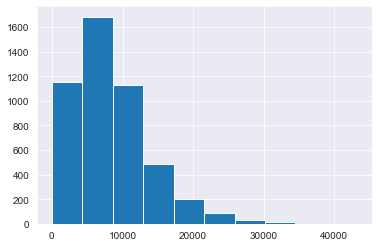

In [161]:
df.steps.hist()

### Time in Heart Rate Zones
Minutes below zone, and in zones 1, 2, and 3.

In [162]:
users_time_in_heart_rate_zones = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "time_in_heart_rate_zones"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_time_in_heart_rate_zones = pd.concat([users_time_in_heart_rate_zones, user_data], axis=0)

# split data column (json format) into two columns
users_time_in_heart_rate_zones["date"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["dateTime"])
users_time_in_heart_rate_zones["minutes_in_default_zone_1"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("IN_DEFAULT_ZONE_1"))
users_time_in_heart_rate_zones["minutes_below_default_zone_1"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("BELOW_DEFAULT_ZONE_1"))
users_time_in_heart_rate_zones["minutes_in_default_zone_2"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("IN_DEFAULT_ZONE_2"))
users_time_in_heart_rate_zones["minutes_in_default_zone_3"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("IN_DEFAULT_ZONE_3"))
users_time_in_heart_rate_zones.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_time_in_heart_rate_zones["date"] = pd.to_datetime(pd.to_datetime(users_time_in_heart_rate_zones["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [163]:
users_time_in_heart_rate_zones.head(20)

,id,date,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3
0,621e2e8e67b776a24055b564,2021-05-26,85.0,1350.0,0.0,0.0
1,621e2e8e67b776a24055b564,2021-05-30,20.0,1160.0,0.0,0.0
2,621e2e8e67b776a24055b564,2021-06-03,68.0,1368.0,0.0,0.0
3,621e2e8e67b776a24055b564,2021-06-07,61.0,1366.0,0.0,0.0
4,621e2e8e67b776a24055b564,2021-06-11,95.0,1289.0,0.0,0.0
5,621e2e8e67b776a24055b564,2021-06-15,53.0,1377.0,5.0,0.0
6,621e2e8e67b776a24055b564,2021-06-19,116.0,1301.0,0.0,0.0
7,621e2e8e67b776a24055b564,2021-06-23,67.0,1361.0,0.0,0.0
8,621e2e8e67b776a24055b564,2021-06-27,47.0,1386.0,0.0,0.0
9,621e2e8e67b776a24055b564,2021-07-01,42.0,1390.0,2.0,0.0


In [164]:
# merge
df = df.merge(users_time_in_heart_rate_zones, how='outer', on=['id', 'date'])

In [165]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,93.0,1.243243,0.987013,0.921642,1.341772,8833.0,83.0,1349.0,0.0,0.0
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,94.0,1.466667,1.142857,0.947566,1.197531,9727.0,56.0,1374.0,4.0,0.0
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,96.0,1.116883,0.858974,1.015038,1.670732,8253.0,85.0,1350.0,0.0,0.0
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,93.0,1.128205,1.129870,1.191729,1.588235,9015.0,90.0,1282.0,0.0,0.0
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,94.0,0.910256,0.871795,1.211896,1.090909,12949.0,146.0,1274.0,4.0,0.0
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,...,95.0,0.846154,0.870130,1.110294,1.170455,25526.0,428.0,986.0,2.0,0.0
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,...,94.0,0.974026,0.909091,1.120438,1.157303,3796.0,20.0,1160.0,0.0,0.0
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,...,96.0,1.025974,1.078947,1.090909,1.311111,9245.0,65.0,1365.0,0.0,0.0
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,...,94.0,1.090909,1.051948,1.137681,1.153846,8422.0,47.0,1369.0,1.0,0.0
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,...,96.0,1.423077,1.233766,0.935252,1.186813,8284.0,71.0,1326.0,0.0,0.0


In [166]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'minutes_below_default_zone_1'], keep=False)].shape[0]))

Duplicates based on ID and Date: 136
Duplicates based on ID and Date and Value: 134


<AxesSubplot:>

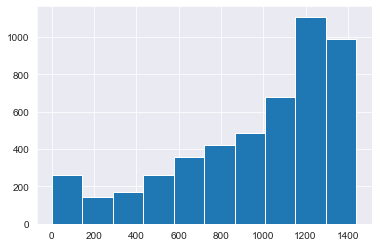

In [167]:
df['minutes_below_default_zone_1'].hist()

<AxesSubplot:>

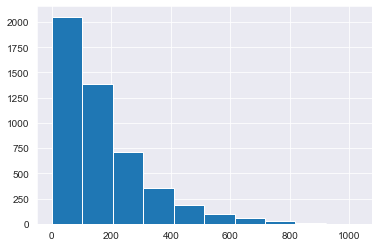

In [168]:
df['minutes_in_default_zone_1'].hist()

<AxesSubplot:>

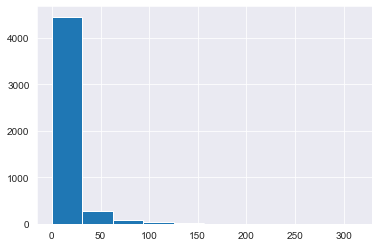

In [169]:
df['minutes_in_default_zone_2'].hist()

<AxesSubplot:>

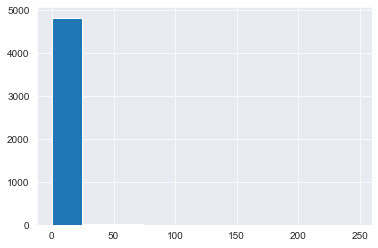

In [170]:
df['minutes_in_default_zone_3'].hist()

### Profile
Demographic Information about the user (N=70).

In [171]:
def get_age(date_of_birth):
    today = date.today()
    return today.year - date_of_birth.year - ((today.month, today.day) < (date_of_birth.month, date_of_birth.day))

In [172]:
users_profiles = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Profile"},
            {"id": user}
        ]},
            # {"id": 1, "data.date_of_birth": 1, "data.gender": 1, "data.height": 1, "data.weight": 1,  "_id": 0}
            {"id": 1, "data.age": 1, "data.gender": 1, "data.bmi": 1,  "_id": 0}
        )
    ))

    users_profiles = pd.concat([users_profiles, user_data], axis=0)

# users_profiles["age"] = users_profiles["data"].apply(lambda d: d["date_of_birth"])
# users_profiles["age"] = pd.to_datetime(users_profiles["age"], format="%Y/%m/%d")
# users_profiles["age"] = users_profiles["age"].apply(lambda d: get_age(d))
# users_profiles["height"] = users_profiles["data"].apply(lambda d: d["height"])
# users_profiles["weight"] = users_profiles["data"].apply(lambda d: d["weight"])
# users_profiles["gender"] = users_profiles["data"].apply(lambda d: d["gender"])


users_profiles["age"] = users_profiles["data"].apply(lambda d: d["age"] if "age" in d else np.NaN)
users_profiles["gender"] = users_profiles["data"].apply(lambda d: d["gender"] if "gender" in d else np.NaN)
users_profiles["bmi"] = users_profiles["data"].apply(lambda d: d["bmi"] if "bmi" in d else np.NaN)

users_profiles.drop(['data'], axis=1, inplace=True)
users_profiles.head(70)

,id,age,gender,bmi
0,621e2e8e67b776a24055b564,<30,MALE,<19
0,621e2eaf67b776a2406b14ac,>=30,FEMALE,<19
0,621e2ed667b776a24085d8d1,<30,FEMALE,23.0
0,621e2ef567b776a24099f889,<30,MALE,28.0
0,621e2efa67b776a2409dd1c3,<30,FEMALE,21.0
...,...,...,...,...
0,621e36c267b776a240ba2756,<30,MALE,20.0
0,621e36dd67b776a240ce9a45,>=30,MALE,24.0
0,621e36f967b776a240e5e7c9,<30,FEMALE,>=25
0,621e375367b776a24021e950,<30,MALE,28.0


In [173]:
# merge
df = df.merge(users_profiles, how='left', on=['id'])

In [174]:
df.head(100)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,0.921642,1.341772,8833.0,83.0,1349.0,0.0,0.0,<30,MALE,<19
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,0.947566,1.197531,9727.0,56.0,1374.0,4.0,0.0,<30,MALE,<19
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,1.015038,1.670732,8253.0,85.0,1350.0,0.0,0.0,<30,MALE,<19
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,1.191729,1.588235,9015.0,90.0,1282.0,0.0,0.0,<30,MALE,<19
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,1.211896,1.090909,12949.0,146.0,1274.0,4.0,0.0,<30,MALE,<19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,621e2eaf67b776a2406b14ac,2021-11-20,34.445559,81.610,10.854,NaN,15.6,82.0,0.833333,0.900,...,1.045662,1.062500,43112.0,574.0,855.0,11.0,0.0,>=30,FEMALE,<19
96,621e2eaf67b776a2406b14ac,2021-11-21,34.620595,70.957,25.925,NaN,15.6,74.0,0.533333,0.775,...,0.904545,0.259259,25177.0,304.0,1131.0,5.0,0.0,>=30,FEMALE,<19
97,621e2eaf67b776a2406b14ac,2021-11-22,34.321482,68.986,28.020,NaN,14.8,83.0,0.800000,0.775,...,0.986301,1.153846,14766.0,263.0,1009.0,4.0,0.0,>=30,FEMALE,<19
98,621e2eaf67b776a2406b14ac,2021-11-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6930.0,140.0,482.0,15.0,0.0,>=30,FEMALE,<19


### Saving to pickle file

In [175]:
df.to_pickle('./data/daily_fitbit_df_unprocessed.pkl')

In [176]:
df = pd.read_pickle('./data/daily_fitbit_df_unprocessed.pkl')

## Integrating SEMA Data
The SEMA ecological ecological momentary assessment surveys include data about the users' daily step goals (maximum once per day) as well as emotions and locations (maximum three times a day)

### Integrating step goals
This field includes the user's daily step goal range (N=1921).

In [177]:
# user goals in SEMA
SEMA_GOALS_TO_MIN = {
    "2000": 0,
    "4999": 2000,
    "7999": 5000,
    "9999": 8000,
    "14999": 10000,
    "19999": 15000,
    "24999": 20000,
    "25000": 25000,
    "NO_GOAL": 0
}

SEMA_GOALS_TO_MAX = {
    "2000": 2000,
    "4999": 5000,
    "7999": 8000,
    "9999": 10000,
    "14999": 15000,
    "19999": 20000,
    "24999": 25000,
    "25000": 30000,
    "NO_GOAL": 0
}

SEMA_LABELS = {
    "2000": "Less than 2000",
    "4999": "2000-4999",
    "7999": "5000-7999",
    "9999": "8000-9999",
    "14999": "10000-14999",
    "19999": "15000-19999",
    "24999": "20000-24999",
    "25000": "More than 25000",
    "NO_GOAL": "No Goal",
    np.nan: "No Goal",
    None: "No Goal"
}

In [178]:
if not os.path.exists("data/users_step_goals_daily.pkl"):
    # Get user self-reported goals from SEMA
    sema_goals = pd.DataFrame(columns=["_id", "user_id", "data"])
    for user in users:
        user_data = pd.DataFrame(list(
                        db.sema.find({ "$and": [
                            { "data.STEPS": { "$ne": "<no-response>" } },
                            {"user_id": user}
                        ] },
                            {"data.STEPS": 1, "id": 1, "user_id": 1, "data.STARTED_TS": 1}
                        )
                    ))

        sema_goals = pd.concat([sema_goals, user_data], axis=0)

    # split data column (json format) into two columns
    sema_goals["timestamp"] = sema_goals["data"].apply(lambda d: d["STARTED_TS"])
    sema_goals["step_goal"] = sema_goals["data"].apply(lambda d: d["STEPS"])
    sema_goals.drop(["data", "_id"], inplace=True, axis=1)

    # convert timestamp to day format
    sema_goals["date"] = pd.to_datetime(sema_goals["timestamp"], infer_datetime_format=True).dt.date
    sema_goals["date"] = pd.to_datetime(sema_goals["date"], infer_datetime_format=True) # convert from object to datetime
    sema_goals.drop(["timestamp"], inplace=True, axis=1)

    # add min goal and max goal columns
    sema_goals['min_goal'] = sema_goals.step_goal.apply(lambda s: SEMA_GOALS_TO_MIN.get(s))
    sema_goals['max_goal'] = sema_goals.step_goal.apply(lambda s: SEMA_GOALS_TO_MAX.get(s))

    # add goal labels
    sema_goals['step_goal_label'] = sema_goals['step_goal'].apply(lambda v: SEMA_LABELS[v])
    sema_goals[['date', 'user_id', 'step_goal', 'min_goal', 'max_goal', 'step_goal_label']].to_pickle('./data/users_step_goals_daily.pkl')

users_step_goals = pd.read_pickle('./data/users_step_goals_daily.pkl')
users_step_goals['id'] = users_step_goals.user_id.copy()
users_step_goals.drop(['user_id'], axis=1, inplace=True)

In [179]:
users_step_goals.head(10)

,date,step_goal,min_goal,max_goal,step_goal_label,id
0,2021-07-18,7999,5000.0,8000.0,5000-7999,621e2e8e67b776a24055b564
1,2021-06-27,7999,5000.0,8000.0,5000-7999,621e2e8e67b776a24055b564
2,2021-07-23,14999,10000.0,15000.0,10000-14999,621e2e8e67b776a24055b564
3,2021-06-03,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
4,2021-07-14,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
5,2021-06-18,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
6,2021-06-20,7999,5000.0,8000.0,5000-7999,621e2e8e67b776a24055b564
7,2021-07-21,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
8,2021-05-25,14999,10000.0,15000.0,10000-14999,621e2e8e67b776a24055b564
9,2021-07-24,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564


In [180]:
# merge
df = df.merge(users_step_goals, how='outer', on=['id', 'date'])

In [181]:
df.head(50)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,step_goal,min_goal,max_goal,step_goal_label
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,1349.0,0.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,1374.0,4.0,0.0,<30,MALE,<19,14999,10000.0,15000.0,10000-14999
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,1350.0,0.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,1282.0,0.0,0.0,<30,MALE,<19,14999,10000.0,15000.0,10000-14999
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,1274.0,4.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,...,986.0,2.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,...,1160.0,0.0,0.0,<30,MALE,<19,4999,2000.0,5000.0,2000-4999
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,...,1365.0,0.0,0.0,<30,MALE,<19,9999,8000.0,10000.0,8000-9999
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,...,1369.0,1.0,0.0,<30,MALE,<19,9999,8000.0,10000.0,8000-9999
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,...,1326.0,0.0,0.0,<30,MALE,<19,9999,8000.0,10000.0,8000-9999


In [182]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'step_goal_label'], keep=False)].shape[0]))

Duplicates based on ID and Date: 148
Duplicates based on ID and Date and Value: 142


In [183]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,step_goal,min_goal,max_goal,step_goal_label
1751,621e301e67b776a240608a72,2021-08-28,31.0584031414,nan,nan,nan,nan,0.0,0.0,0.0,...,154.0,65.0,0.0,<30,FEMALE,19.0,nan,nan,nan,nan
1752,621e301e67b776a240608a72,2021-08-28,31.0584031414,nan,nan,nan,nan,0.0,0.0,0.0,...,219.0,100.0,0.0,<30,FEMALE,19.0,nan,nan,nan,nan
7426,621e362467b776a2404ad513,2021-04-10,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,2000,0.0,2000.0,Less than 2000
7427,621e362467b776a2404ad513,2021-04-10,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,19999,15000.0,20000.0,15000-19999
7432,621e362467b776a2404ad513,2021-04-22,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,14999,10000.0,15000.0,10000-14999
7433,621e362467b776a2404ad513,2021-04-22,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,4999,2000.0,5000.0,2000-4999
7441,621e362467b776a2404ad513,2021-04-09,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,9999,8000.0,10000.0,8000-9999
7442,621e362467b776a2404ad513,2021-04-09,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,7999,5000.0,8000.0,5000-7999


In [184]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7474
Size after duplicate elimination: 7400


### Integrating Εmotions & Location

In [185]:
# read data
if not os.path.exists('./data/sema_mood_place.pkl'):
    # Get user self-reported goals from SEMA
    users = db.sema.distinct('user_id')

    sema_mood = pd.DataFrame(columns=["_id", "user_id", "data"])
    for user in users:
        user_data = pd.DataFrame(list(
                        db.sema.find({
                            "$or": [
                                {
                                    "$and": [
                                        { "data.MOOD": { "$ne": "<no-response>" } },
                                        {"data.MOOD": { "$ne": None }},
                                        {"user_id": user}
                                    ]
                                },
                                {
                                    "$and": [
                                        { "data.PLACE": { "$ne": "<no-response>" } },
                                        {"data.PLACE": { "$ne": None }},
                                        {"user_id": user}
                                    ]
                                }
                            ]
                        },
                            {"data.MOOD": 1, "data.PLACE": 1, "id": 1, "_id": 0, "user_id": 1, "data.STARTED_TS": 1}
                        )
                    ))

        sema_mood = pd.concat([sema_mood, user_data], axis=0)

sema_mood["date"] = pd.to_datetime(pd.to_datetime(sema_mood["data"].apply(lambda d: d["STARTED_TS"]), infer_datetime_format=True).dt.date, infer_datetime_format=True)
sema_mood["time"] = pd.to_datetime(sema_mood["data"].apply(lambda d: d["STARTED_TS"]), infer_datetime_format=True).dt.time
sema_mood["data.MOOD"] = sema_mood["data"].apply(lambda d: d["MOOD"])
sema_mood["data.PLACE"] = sema_mood["data"].apply(lambda d: d["PLACE"])
sema_mood.drop(["_id", "data"], axis=1, inplace=True)
sema_mood.to_pickle('./data/sema_mood_place.pkl')

In [186]:
infile = open('./data/sema_mood_place.pkl','rb')
sema = pickle.load(infile)
infile.close()

sema.head() # year-month-day e.g. 2021-05-24

,user_id,date,time,data.MOOD,data.PLACE
0,621e2e8e67b776a24055b564,2021-06-10,16:38:00,NEUTRAL,WORK/SCHOOL
1,621e2e8e67b776a24055b564,2021-06-13,14:35:00,NEUTRAL,HOME
2,621e2e8e67b776a24055b564,2021-07-24,15:22:00,HAPPY,OUTDOORS
3,621e2e8e67b776a24055b564,2021-06-01,10:15:00,HAPPY,OUTDOORS
4,621e2e8e67b776a24055b564,2021-06-21,18:32:00,TIRED,OUTDOORS


In [187]:
# process dateTime to date
# sema['date'] = pd.to_datetime(sema['Dates'])
# sema.drop(['data.CREATED_TS', 'Dates'], axis=1, inplace=True)

# replace not common moods
sema['data.MOOD'] = sema['data.MOOD'].apply(lambda mood: 'SAD' if mood == 'SADNESS' else ('HAPPY' if mood == 'JOY' else mood))
sema = sema[(sema['data.MOOD'] != 'FEAR') & (sema['data.MOOD'] != 'SURPRISE') & (sema['data.MOOD'] != 'ANGER') & (sema['data.MOOD'] != '<no-response>')]
print(sema['data.MOOD'].value_counts())
print(sema['data.PLACE'].value_counts())
# drop unessecary columns
sema.drop(['time'], axis=1, inplace=True)

sema.head()

RESTED/RELAXED    1179
TIRED             1126
NEUTRAL            822
HAPPY              790
TENSE/ANXIOUS      620
ALERT              345
SAD                149
Name: data.MOOD, dtype: int64
HOME             2960
WORK/SCHOOL       869
OUTDOORS          381
HOME_OFFICE       309
TRANSIT           224
ENTERTAINMENT     209
OTHER              60
GYM                18
Name: data.PLACE, dtype: int64


,user_id,date,data.MOOD,data.PLACE
0,621e2e8e67b776a24055b564,2021-06-10,NEUTRAL,WORK/SCHOOL
1,621e2e8e67b776a24055b564,2021-06-13,NEUTRAL,HOME
2,621e2e8e67b776a24055b564,2021-07-24,HAPPY,OUTDOORS
3,621e2e8e67b776a24055b564,2021-06-01,HAPPY,OUTDOORS
4,621e2e8e67b776a24055b564,2021-06-21,TIRED,OUTDOORS


In [188]:
sema_moods = pd.get_dummies(sema['data.MOOD'])
sema_places = pd.get_dummies(sema['data.PLACE'])
print(sema_moods.head())
print(sema_places.head())

   ALERT  HAPPY  NEUTRAL  RESTED/RELAXED  SAD  TENSE/ANXIOUS  TIRED
0      0      0        1               0    0              0      0
1      0      0        1               0    0              0      0
2      0      1        0               0    0              0      0
3      0      1        0               0    0              0      0
4      0      0        0               0    0              0      1
   ENTERTAINMENT  GYM  HOME  HOME_OFFICE  OTHER  OUTDOORS  TRANSIT  \
0              0    0     0            0      0         0        0   
1              0    0     1            0      0         0        0   
2              0    0     0            0      0         1        0   
3              0    0     0            0      0         1        0   
4              0    0     0            0      0         1        0   

   WORK/SCHOOL  
0            1  
1            0  
2            0  
3            0  
4            0  


In [189]:
# combine one-hot encoding with actual df
sema = pd.concat([sema, sema_moods, sema_places], axis=1)
sema.drop(['data.MOOD', 'data.PLACE'], axis=1, inplace=True)
sema.head(50)

,user_id,date,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-06-10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,621e2e8e67b776a24055b564,2021-06-13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,621e2e8e67b776a24055b564,2021-07-24,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,621e2e8e67b776a24055b564,2021-06-01,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,621e2e8e67b776a24055b564,2021-06-21,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5,621e2e8e67b776a24055b564,2021-05-27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
6,621e2e8e67b776a24055b564,2021-06-15,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
7,621e2e8e67b776a24055b564,2021-07-22,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
8,621e2e8e67b776a24055b564,2021-06-02,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
9,621e2e8e67b776a24055b564,2021-06-17,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [190]:
sema_grouped = sema.groupby(['date', 'user_id']).max()
sema_grouped.reset_index(drop=False, inplace=True)
sema_grouped['id'] = sema_grouped['user_id'].copy()
sema_grouped.drop(['user_id'], axis=1, inplace=True)
sema_grouped.reset_index(drop=True, inplace=True)
sema_grouped.id = sema_grouped.id.swifter.apply(lambda id: ObjectId(id))
sema_grouped.head()

Pandas Apply:   0%|          | 0/2290 [00:00<?, ?it/s]

,date,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL,id
0,2021-04-22,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
1,2021-04-23,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
2,2021-04-24,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
3,2021-04-25,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
4,2021-04-26,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513


(array([18748., 18779., 18809., 18840., 18871., 18901., 18932., 18962.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

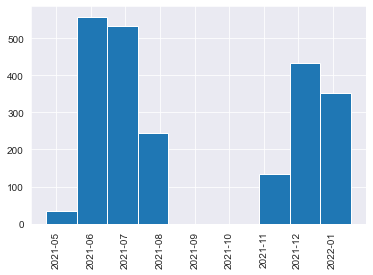

In [191]:
sema_grouped.date.hist()
plt.xticks(rotation=90)

In [192]:
# merge
df = df.merge(sema_grouped, how='outer', on=['id', 'date'])

In [193]:
df.head(50)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [194]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'full_sleep_breathing_rate'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


In [195]:
df.to_pickle('./data/daily_fitbit_sema_df_unprocessed.pkl')

In [258]:
df = pd.read_pickle('./data/Daily Anonymized Files/daily_fitbit_sema_df_unprocessed.pkl')

In [260]:
df.shape[0]

7410

In [261]:
df.to_csv('./data/daily_fitbit_sema_df_unprocessed.csv')

## Integrating Surveys Data
During the experiment the participants completed the following surveys:
* State-Trait Anxiety Inventory (STAI): 323 weekly responses
* Positive Affect Negative Affect Scale (PANAS): 311 weekly responses
* Physical Activity Readiness Questionnaire (PAR-Q): 58 pre-experiment responses
* Behavioral Regulation in Exercise Questionnaire (BREQ-2): 101 pre- and post-experiment responses
* Big Five Personality Test: 53 pre-experiment responses
* TTM Stages and Processes of Behavior Change: 104 pre- and post-experiment responses
* Demographics Questionnaire: 63 pre-experiment responses


In [197]:
df = pd.read_pickle('./data/daily_fitbit_sema_df_unprocessed.pkl')

In [198]:
df.head(50)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,82.0,0.900000,0.750,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,81.0,0.833333,0.775,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,84.0,0.933333,0.725,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,84.0,0.833333,0.800,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,83.0,0.933333,0.775,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Integrating Personality Type Responses

In [199]:
users_personality = pd.DataFrame(columns=["user_id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.surveys.find({"$and": [
            {"type": "bfpt"},
            {"user_id": user}
        ]},
            {"_id": 0}
        )
    ))

    users_personality = pd.concat([users_personality, user_data], axis=0)

users_personality["submitdate"] = users_personality["data"].apply(lambda d: d["submitdate"])
users_personality["submitdate"] = pd.to_datetime(users_personality["submitdate"], infer_datetime_format=True).dt.date

for ipip in range(1,51):
    if ipip < 10:
        col_name = "ipip[SQ00{}]".format(ipip)
    else:
        col_name = "ipip[SQ0{}]".format(ipip)
    users_personality[col_name] = users_personality["data"].apply(lambda d: d[col_name])

users_personality.drop(['data'], axis=1, inplace=True)

print("We have {} survey responses for the IPIP (Big-5 Personality) scale.".format(users_personality.shape[0]))

We have 50 survey responses for the IPIP (Big-5 Personality) scale.


In [200]:
users_personality.drop_duplicates(subset=['user_id'], keep="first")
print("We have {} survey responses for the IPIP (Big-5 Personality) scale after duplicates elimination.".format(users_personality.shape[0]))

We have 50 survey responses for the IPIP (Big-5 Personality) scale after duplicates elimination.


In [201]:
bfpt_scoring = pd.read_csv("data/utils/BFPT-Coding.csv", sep=";")
bfpt_scoring.head()

,code,factor,plus
0,ipip[SQ001],1,True
1,ipip[SQ002],2,False
2,ipip[SQ003],3,True
3,ipip[SQ004],4,False
4,ipip[SQ005],5,True


In [202]:
ipip_plus = bfpt_scoring[bfpt_scoring.plus == True].code
ipip_minus = bfpt_scoring[bfpt_scoring.plus == False].code
ipip_minus

1     ipip[SQ002]
3     ipip[SQ004]
5     ipip[SQ006]
7     ipip[SQ008]
9     ipip[SQ010]
11    ipip[SQ012]
13    ipip[SQ014]
15    ipip[SQ016]
17    ipip[SQ018]
19    ipip[SQ020]
21    ipip[SQ022]
23    ipip[SQ024]
25    ipip[SQ026]
27    ipip[SQ028]
28    ipip[SQ029]
29    ipip[SQ030]
31    ipip[SQ032]
33    ipip[SQ034]
35    ipip[SQ036]
37    ipip[SQ038]
38    ipip[SQ039]
43    ipip[SQ044]
45    ipip[SQ046]
48    ipip[SQ049]
Name: code, dtype: object

In [203]:
# Converting IPIP Item Responses to Scale Scores
# For + keyed items, the response "Very Inaccurate" is assigned a value of 1, "Moderately Inaccurate" a value of 2, "Neither Inaccurate nor Accurate" a 3, "Moderately Accurate" a 4, and "Very Accurate" a value of 5.
# For - keyed items, the response "Very Inaccurate" is assigned a value of 5, "Moderately Inaccurate" a value of 4, "Neither Inaccurate nor Accurate" a 3, "Moderately Accurate" a 2, and "Very Accurate" a value of 1.
def inverse_score(score, min, max):
    return max - score + min

# def inverse_score(score):
#     if score == 1:
#         return 5
#     if score == 2:
#         return 4
#     if score == 3:
#         return 3
#     if score == 4:
#         return 2
#     return 1

print("Users' personality responses before inverting minus keyed items:")
print(users_personality.iloc[:2,3:5].head())

for col in users_personality.columns:
    # inversing scores for the minus keyed items; the plus keyed items stay as is
    if col in ipip_minus.values:
        users_personality[col] = users_personality[col].apply(lambda score: inverse_score(score, 1, 5))

print("Users' personality responses after inverting minus keyed items:")
print(users_personality.iloc[:2,3:5].head())

Users' personality responses before inverting minus keyed items:
   ipip[SQ001]  ipip[SQ002]
0          1.0          1.0
0          3.0          2.0
Users' personality responses after inverting minus keyed items:
   ipip[SQ001]  ipip[SQ002]
0          1.0          5.0
0          3.0          4.0


In [204]:
ipip_extraversion = bfpt_scoring[bfpt_scoring.factor == 1].code
ipip_agreeableness = bfpt_scoring[bfpt_scoring.factor == 2].code
ipip_conscientiousness = bfpt_scoring[bfpt_scoring.factor == 3].code
ipip_stability = bfpt_scoring[bfpt_scoring.factor == 4].code
ipip_intellect = bfpt_scoring[bfpt_scoring.factor == 5].code

In [205]:
# find a summary per factor per user
# Factor I (Surgency or Extraversion)
users_personality["extraversion"] = users_personality[ipip_extraversion].sum(axis=1)
# Factor II (Agreeableness)
users_personality["agreeableness"] = users_personality[ipip_agreeableness].sum(axis=1)
# Factor III (Conscientiousness)
users_personality["conscientiousness"] = users_personality[ipip_conscientiousness].sum(axis=1)
# Factor IV (Emotional Stability)
users_personality["stability"] = users_personality[ipip_stability].sum(axis=1)
# Factor V (Intellect or Imagination)
users_personality["intellect"] = users_personality[ipip_intellect].sum(axis=1)

#### Factor I (Surgency or Extraversion)

count    50.000000
mean     30.140000
std       8.164158
min      13.000000
25%      22.000000
50%      31.500000
75%      36.500000
max      45.000000
Name: extraversion, dtype: float64


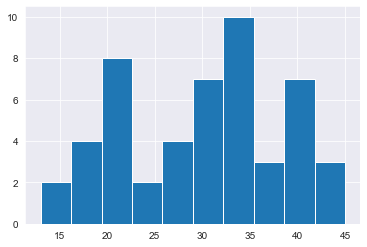

In [206]:
users_personality.extraversion.hist()

print(users_personality.describe().extraversion)

#### Factor II (Agreeableness)

count    50.000000
mean     38.280000
std       6.353659
min      20.000000
25%      34.000000
50%      39.000000
75%      43.750000
max      49.000000
Name: agreeableness, dtype: float64


<AxesSubplot:>

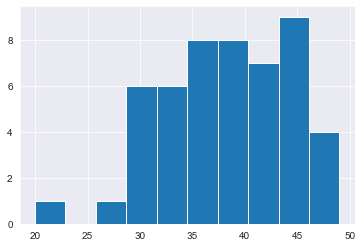

In [207]:
print(users_personality.describe().agreeableness)

users_personality.agreeableness.hist()

#### Factor III (Conscientiousness)

count    50.000000
mean     33.440000
std       6.916883
min      21.000000
25%      28.000000
50%      33.500000
75%      39.000000
max      46.000000
Name: conscientiousness, dtype: float64


<AxesSubplot:>

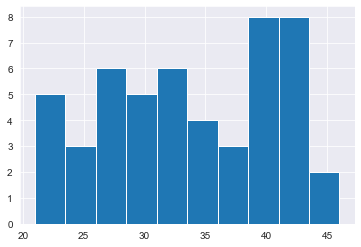

In [208]:
print(users_personality.describe().conscientiousness)

users_personality.conscientiousness.hist()

#### Factor IV (Emotional Stability)

count    50.00000
mean     29.84000
std       8.18251
min      11.00000
25%      24.25000
50%      31.00000
75%      34.75000
max      46.00000
Name: stability, dtype: float64


<AxesSubplot:>

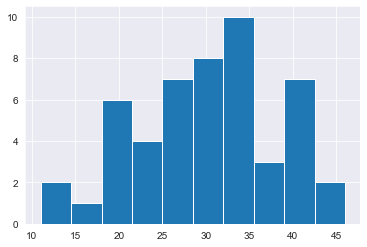

In [209]:
print(users_personality.describe().stability)

users_personality.stability.hist()

#### Factor V (Intellect or Imagination)

count    50.000000
mean     36.600000
std       5.268311
min      27.000000
25%      34.000000
50%      36.000000
75%      40.000000
max      48.000000
Name: intellect, dtype: float64


<AxesSubplot:>

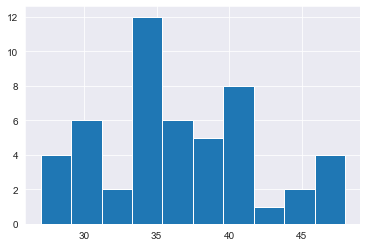

In [210]:
print(users_personality.describe().intellect)

users_personality.intellect.hist()

To interpret individuals' scores, one might calculate the mean and standard deviation (SD) for a sample of persons, usually of the same sex and a particular age range, and interpret scores within one-half SD of the mean as "average." Scores outside that range can be interpreted as "low" or "high." If the scores are normally distributed, this would result in approximately 38% of persons being classified as average, about 31% as low, and 31% as high.

In [211]:
# incorporate gender information
users_personality = users_personality.merge(df[['id','gender']].drop_duplicates(), how='left', left_on='user_id', right_on='id')
users_personality

,user_id,type,submitdate,ipip[SQ001],ipip[SQ002],ipip[SQ003],ipip[SQ004],ipip[SQ005],ipip[SQ006],ipip[SQ007],...,ipip[SQ048],ipip[SQ049],ipip[SQ050],extraversion,agreeableness,conscientiousness,stability,intellect,id,gender
0,621e2e8e67b776a24055b564,bfpt,2021-05-31,1.0,5.0,5.0,5.0,3.0,1.0,3.0,...,5.0,5.0,4.0,21.0,33.0,45.0,42.0,40.0,621e2e8e67b776a24055b564,MALE
1,621e2eaf67b776a2406b14ac,bfpt,2021-11-29,3.0,4.0,3.0,1.0,5.0,4.0,4.0,...,3.0,1.0,3.0,32.0,45.0,30.0,18.0,41.0,621e2eaf67b776a2406b14ac,FEMALE
2,621e2ed667b776a24085d8d1,bfpt,2021-06-07,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,2.0,3.0,4.0,40.0,43.0,22.0,28.0,34.0,621e2ed667b776a24085d8d1,FEMALE
3,621e2f3967b776a240c654db,bfpt,2021-05-31,3.0,4.0,3.0,5.0,3.0,2.0,4.0,...,3.0,4.0,4.0,25.0,34.0,30.0,39.0,37.0,621e2f3967b776a240c654db,MALE
4,621e2f6167b776a240e082a9,bfpt,2021-06-01,5.0,4.0,2.0,2.0,3.0,4.0,4.0,...,2.0,2.0,2.0,41.0,41.0,30.0,34.0,30.0,621e2f6167b776a240e082a9,FEMALE
5,621e2f7a67b776a240f14425,bfpt,2021-05-31,3.0,2.0,4.0,4.0,3.0,2.0,4.0,...,4.0,4.0,3.0,29.0,38.0,43.0,39.0,35.0,621e2f7a67b776a240f14425,MALE
6,621e2f9167b776a240011ccb,bfpt,2021-11-28,2.0,5.0,3.0,1.0,4.0,3.0,4.0,...,4.0,2.0,4.0,21.0,45.0,31.0,18.0,39.0,621e2f9167b776a240011ccb,FEMALE
7,621e2fb367b776a24015accd,bfpt,2021-05-31,4.0,3.0,3.0,2.0,4.0,4.0,3.0,...,2.0,4.0,4.0,37.0,36.0,29.0,27.0,41.0,621e2fb367b776a24015accd,MALE
8,621e2fce67b776a240279baa,bfpt,2021-05-31,4.0,5.0,4.0,2.0,2.0,5.0,4.0,...,2.0,3.0,4.0,34.0,42.0,35.0,27.0,35.0,621e2fce67b776a240279baa,MALE
9,621e2ff067b776a2403eb737,bfpt,2021-11-29,4.0,4.0,2.0,1.0,4.0,2.0,4.0,...,2.0,1.0,2.0,33.0,44.0,23.0,11.0,30.0,621e2ff067b776a2403eb737,FEMALE


In [212]:
users_personality.drop_duplicates(subset='id', inplace=True)
users_personality.gender.fillna('FEMALE', inplace=True)
users_personality.drop(['id'], inplace=True, axis=1)

In [213]:
MEAN_1_FEMALE, STD_1_FEMALE = users_personality.groupby('gender').extraversion.mean()["FEMALE"], users_personality.groupby('gender').extraversion.std()["FEMALE"]
MEAN_1_MALE, STD_1_MALE = users_personality.groupby('gender').extraversion.mean()["MALE"], users_personality.groupby('gender').extraversion.std()["MALE"]

MEAN_2_FEMALE, STD_2_FEMALE = users_personality.groupby('gender').agreeableness.mean()["FEMALE"], users_personality.groupby('gender').agreeableness.std()["FEMALE"]
MEAN_2_MALE, STD_2_MALE = users_personality.groupby('gender').agreeableness.mean()["MALE"], users_personality.groupby('gender').agreeableness.std()["MALE"]

MEAN_3_FEMALE, STD_3_FEMALE = users_personality.groupby('gender').conscientiousness.mean()["FEMALE"], users_personality.groupby('gender').conscientiousness.std()["FEMALE"]
MEAN_3_MALE, STD_3_MALE = users_personality.groupby('gender').conscientiousness.mean()["MALE"], users_personality.groupby('gender').conscientiousness.std()["MALE"]

MEAN_4_FEMALE, STD_4_FEMALE = users_personality.groupby('gender').stability.mean()["FEMALE"], users_personality.groupby('gender').stability.std()["FEMALE"]
MEAN_4_MALE, STD_4_MALE = users_personality.groupby('gender').stability.mean()["MALE"], users_personality.groupby('gender').stability.std()["MALE"]

MEAN_5_FEMALE, STD_5_FEMALE = users_personality.groupby('gender').intellect.mean()["FEMALE"], users_personality.groupby('gender').intellect.std()["FEMALE"]
MEAN_5_MALE, STD_5_MALE = users_personality.groupby('gender').intellect.mean()["MALE"], users_personality.groupby('gender').intellect.std()["MALE"]

In [214]:
def get_personality_category(score, mean, std):
    if score > mean + 0.5*std:
        return 'HIGH'
    if score < mean - 0.5*std:
        return 'LOW'
    return 'AVERAGE'

users_personality['ipip_extraversion_category'] = users_personality.apply(lambda row: get_personality_category(row.extraversion, MEAN_1_MALE, STD_1_MALE) if row.gender == "MALE" else get_personality_category(row.extraversion, MEAN_1_FEMALE, STD_1_FEMALE), axis=1)

users_personality['ipip_agreeableness_category'] = users_personality.apply(lambda row: get_personality_category(row.agreeableness, MEAN_2_MALE, STD_2_MALE) if row.gender == "MALE" else get_personality_category(row.agreeableness, MEAN_2_FEMALE, STD_2_FEMALE), axis=1)

users_personality['ipip_conscientiousness_category'] = users_personality.apply(lambda row: get_personality_category(row.conscientiousness, MEAN_3_MALE, STD_3_MALE) if row.gender == "MALE" else get_personality_category(row.conscientiousness, MEAN_3_FEMALE, STD_3_FEMALE), axis=1)

users_personality['ipip_stability_category'] = users_personality.apply(lambda row: get_personality_category(row.stability, MEAN_4_MALE, STD_4_MALE) if row.gender == "MALE" else get_personality_category(row.stability, MEAN_4_FEMALE, STD_4_FEMALE), axis=1)

users_personality['ipip_intellect_category'] = users_personality.apply(lambda row: get_personality_category(row.intellect, MEAN_5_MALE, STD_5_MALE) if row.gender == "MALE" else get_personality_category(row.intellect, MEAN_5_FEMALE, STD_5_FEMALE), axis=1)

users_personality.head(10)

,user_id,type,submitdate,ipip[SQ001],ipip[SQ002],ipip[SQ003],ipip[SQ004],ipip[SQ005],ipip[SQ006],ipip[SQ007],...,agreeableness,conscientiousness,stability,intellect,gender,ipip_extraversion_category,ipip_agreeableness_category,ipip_conscientiousness_category,ipip_stability_category,ipip_intellect_category
0,621e2e8e67b776a24055b564,bfpt,2021-05-31,1.0,5.0,5.0,5.0,3.0,1.0,3.0,...,33.0,45.0,42.0,40.0,MALE,LOW,LOW,HIGH,HIGH,AVERAGE
1,621e2eaf67b776a2406b14ac,bfpt,2021-11-29,3.0,4.0,3.0,1.0,5.0,4.0,4.0,...,45.0,30.0,18.0,41.0,FEMALE,AVERAGE,HIGH,AVERAGE,LOW,HIGH
2,621e2ed667b776a24085d8d1,bfpt,2021-06-07,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,43.0,22.0,28.0,34.0,FEMALE,HIGH,AVERAGE,LOW,AVERAGE,AVERAGE
3,621e2f3967b776a240c654db,bfpt,2021-05-31,3.0,4.0,3.0,5.0,3.0,2.0,4.0,...,34.0,30.0,39.0,37.0,MALE,AVERAGE,AVERAGE,LOW,HIGH,AVERAGE
4,621e2f6167b776a240e082a9,bfpt,2021-06-01,5.0,4.0,2.0,2.0,3.0,4.0,4.0,...,41.0,30.0,34.0,30.0,FEMALE,HIGH,AVERAGE,AVERAGE,HIGH,LOW
5,621e2f7a67b776a240f14425,bfpt,2021-05-31,3.0,2.0,4.0,4.0,3.0,2.0,4.0,...,38.0,43.0,39.0,35.0,MALE,AVERAGE,AVERAGE,HIGH,HIGH,AVERAGE
6,621e2f9167b776a240011ccb,bfpt,2021-11-28,2.0,5.0,3.0,1.0,4.0,3.0,4.0,...,45.0,31.0,18.0,39.0,FEMALE,LOW,HIGH,AVERAGE,LOW,HIGH
7,621e2fb367b776a24015accd,bfpt,2021-05-31,4.0,3.0,3.0,2.0,4.0,4.0,3.0,...,36.0,29.0,27.0,41.0,MALE,HIGH,AVERAGE,LOW,LOW,HIGH
8,621e2fce67b776a240279baa,bfpt,2021-05-31,4.0,5.0,4.0,2.0,2.0,5.0,4.0,...,42.0,35.0,27.0,35.0,MALE,HIGH,HIGH,AVERAGE,LOW,AVERAGE
9,621e2ff067b776a2403eb737,bfpt,2021-11-29,4.0,4.0,2.0,1.0,4.0,2.0,4.0,...,44.0,23.0,11.0,30.0,FEMALE,AVERAGE,HIGH,LOW,LOW,LOW


In [215]:
print(users_personality[['gender', 'ipip_extraversion_category']].value_counts())
print(users_personality[['gender', 'ipip_agreeableness_category']].value_counts())
print(users_personality[['gender', 'ipip_conscientiousness_category']].value_counts())
print(users_personality[['gender', 'ipip_stability_category']].value_counts())
print(users_personality[['gender', 'ipip_intellect_category']].value_counts())

gender  ipip_extraversion_category
MALE    HIGH                          11
        AVERAGE                       10
        LOW                            9
FEMALE  AVERAGE                        8
        HIGH                           6
        LOW                            6
dtype: int64
gender  ipip_agreeableness_category
MALE    AVERAGE                        12
FEMALE  HIGH                            9
MALE    HIGH                            9
        LOW                             9
FEMALE  AVERAGE                         6
        LOW                             5
dtype: int64
gender  ipip_conscientiousness_category
MALE    HIGH                               13
        LOW                                10
FEMALE  AVERAGE                             8
MALE    AVERAGE                             7
FEMALE  HIGH                                6
        LOW                                 6
dtype: int64
gender  ipip_stability_category
MALE    AVERAGE                    11
      

In [216]:
users_personality = users_personality[users_personality.columns.drop(list(users_personality.filter(regex='ipip\[SQ')))]
users_personality

,user_id,type,submitdate,extraversion,agreeableness,conscientiousness,stability,intellect,gender,ipip_extraversion_category,ipip_agreeableness_category,ipip_conscientiousness_category,ipip_stability_category,ipip_intellect_category
0,621e2e8e67b776a24055b564,bfpt,2021-05-31,21.0,33.0,45.0,42.0,40.0,MALE,LOW,LOW,HIGH,HIGH,AVERAGE
1,621e2eaf67b776a2406b14ac,bfpt,2021-11-29,32.0,45.0,30.0,18.0,41.0,FEMALE,AVERAGE,HIGH,AVERAGE,LOW,HIGH
2,621e2ed667b776a24085d8d1,bfpt,2021-06-07,40.0,43.0,22.0,28.0,34.0,FEMALE,HIGH,AVERAGE,LOW,AVERAGE,AVERAGE
3,621e2f3967b776a240c654db,bfpt,2021-05-31,25.0,34.0,30.0,39.0,37.0,MALE,AVERAGE,AVERAGE,LOW,HIGH,AVERAGE
4,621e2f6167b776a240e082a9,bfpt,2021-06-01,41.0,41.0,30.0,34.0,30.0,FEMALE,HIGH,AVERAGE,AVERAGE,HIGH,LOW
5,621e2f7a67b776a240f14425,bfpt,2021-05-31,29.0,38.0,43.0,39.0,35.0,MALE,AVERAGE,AVERAGE,HIGH,HIGH,AVERAGE
6,621e2f9167b776a240011ccb,bfpt,2021-11-28,21.0,45.0,31.0,18.0,39.0,FEMALE,LOW,HIGH,AVERAGE,LOW,HIGH
7,621e2fb367b776a24015accd,bfpt,2021-05-31,37.0,36.0,29.0,27.0,41.0,MALE,HIGH,AVERAGE,LOW,LOW,HIGH
8,621e2fce67b776a240279baa,bfpt,2021-05-31,34.0,42.0,35.0,27.0,35.0,MALE,HIGH,HIGH,AVERAGE,LOW,AVERAGE
9,621e2ff067b776a2403eb737,bfpt,2021-11-29,33.0,44.0,23.0,11.0,30.0,FEMALE,AVERAGE,HIGH,LOW,LOW,LOW


In [217]:
if not os.path.exists("data/surveys"):
    os.makedirs("data/surveys")

In [218]:
users_personality.to_csv("data/surveys/personality.csv")
users_personality.to_pickle("data/surveys/personality.pkl")

### Integrating BREQ-2 Type Responses

In [219]:
users_breq = pd.DataFrame(columns=["user_id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.surveys.find({"$and": [
            {"type": "breq"},
            {"user_id": user}
        ]},
            {"_id": 0}
        )
    ))

    users_breq = pd.concat([users_breq, user_data], axis=0)

users_breq["submitdate"] = users_breq["data"].apply(lambda d: d["submitdate"])
users_breq["submitdate"] = pd.to_datetime(users_breq["submitdate"], infer_datetime_format=True).dt.date

for engage in range(1,20):
    if engage < 10:
        col_name = "engage[SQ00{}]".format(engage)
    else:
        col_name = "engage[SQ0{}]".format(engage)
    users_breq[col_name] = users_breq["data"].apply(lambda d: d[col_name])

users_breq.drop(['data'], axis=1, inplace=True)

print("We have {} survey responses for the BREQ-2 scale.".format(users_breq.shape[0]))

We have 95 survey responses for the BREQ-2 scale.


In [220]:
users_breq

,user_id,type,submitdate,engage[SQ001],engage[SQ002],engage[SQ003],engage[SQ004],engage[SQ005],engage[SQ006],engage[SQ007],...,engage[SQ010],engage[SQ011],engage[SQ012],engage[SQ013],engage[SQ014],engage[SQ015],engage[SQ016],engage[SQ017],engage[SQ018],engage[SQ019]
0,621e2e8e67b776a24055b564,breq,2021-05-31,1,1,5,5,1,1,1,...,4,1,1,1,4,4,1,1,4,1
1,621e2e8e67b776a24055b564,breq,2021-07-26,1,2,5,4,1,1,2,...,4,1,1,1,4,4,1,1,4,1
0,621e2eaf67b776a2406b14ac,breq,2021-11-29,1,1,5,3,1,1,2,...,4,1,1,2,5,4,1,3,4,2
1,621e2eaf67b776a2406b14ac,breq,2022-01-17,2,4,5,4,1,1,1,...,4,1,1,2,5,3,1,2,3,1
0,621e2ed667b776a24085d8d1,breq,2021-06-07,3,4,3,1,3,1,1,...,1,3,3,4,4,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e36c267b776a240ba2756,breq,2021-05-31,1,1,5,5,1,1,1,...,5,1,1,1,4,5,1,1,4,1
0,621e36f967b776a240e5e7c9,breq,2021-05-31,3,5,5,3,1,1,5,...,3,2,1,4,5,3,1,2,4,1
1,621e36f967b776a240e5e7c9,breq,2021-07-26,2,5,5,3,1,2,5,...,3,1,1,5,5,3,2,4,4,1
0,621e375b67b776a240290cdc,breq,2021-06-01,1,3,5,2,1,1,1,...,3,1,1,1,5,3,1,2,3,1


In [221]:
# find a mean per factor per user
users_breq["breq_amotivation"] = users_breq[["engage[SQ005]", "engage[SQ009]", "engage[SQ012]", "engage[SQ019]"]].mean(axis=1)
users_breq["breq_external_regulation"] = users_breq[["engage[SQ001]", "engage[SQ006]", "engage[SQ011]", "engage[SQ016]"]].mean(axis=1)
users_breq["breq_introjected_regulation"] = users_breq[["engage[SQ002]", "engage[SQ007]", "engage[SQ013]"]].mean(axis=1)
users_breq["breq_identified_regulation"] = users_breq[["engage[SQ003]", "engage[SQ008]", "engage[SQ014]", "engage[SQ017]"]].mean(axis=1)
users_breq["breq_intrinsic_regulation"] = users_breq[["engage[SQ004]", "engage[SQ010]", "engage[SQ015]", "engage[SQ018]"]].mean(axis=1)
users_breq

,user_id,type,submitdate,engage[SQ001],engage[SQ002],engage[SQ003],engage[SQ004],engage[SQ005],engage[SQ006],engage[SQ007],...,engage[SQ015],engage[SQ016],engage[SQ017],engage[SQ018],engage[SQ019],breq_amotivation,breq_external_regulation,breq_introjected_regulation,breq_identified_regulation,breq_intrinsic_regulation
0,621e2e8e67b776a24055b564,breq,2021-05-31,1,1,5,5,1,1,1,...,4,1,1,4,1,1.00,1.00,1.000000,3.50,4.25
1,621e2e8e67b776a24055b564,breq,2021-07-26,1,2,5,4,1,1,2,...,4,1,1,4,1,1.00,1.00,1.666667,3.50,4.00
0,621e2eaf67b776a2406b14ac,breq,2021-11-29,1,1,5,3,1,1,2,...,4,1,3,4,2,1.25,1.00,1.666667,4.50,3.75
1,621e2eaf67b776a2406b14ac,breq,2022-01-17,2,4,5,4,1,1,1,...,3,1,2,3,1,1.00,1.25,2.333333,4.00,3.50
0,621e2ed667b776a24085d8d1,breq,2021-06-07,3,4,3,1,3,1,1,...,1,1,1,1,2,2.75,2.00,3.000000,2.50,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e36c267b776a240ba2756,breq,2021-05-31,1,1,5,5,1,1,1,...,5,1,1,4,1,1.00,1.00,1.000000,3.75,4.75
0,621e36f967b776a240e5e7c9,breq,2021-05-31,3,5,5,3,1,1,5,...,3,1,2,4,1,1.00,1.75,4.666667,4.00,3.25
1,621e36f967b776a240e5e7c9,breq,2021-07-26,2,5,5,3,1,2,5,...,3,2,4,4,1,1.00,1.75,5.000000,4.75,3.25
0,621e375b67b776a240290cdc,breq,2021-06-01,1,3,5,2,1,1,1,...,3,1,2,3,1,1.00,1.00,1.666667,3.50,2.75


In [222]:
temp = users_breq[["breq_amotivation", "breq_external_regulation", "breq_introjected_regulation", "breq_identified_regulation", "breq_intrinsic_regulation"]].agg(['idxmax','max'], axis=1).mask(lambda x: x['max'].eq(0))
users_breq.loc[:, "breq_self_determination"] = temp.loc[:, "idxmax"]
users_breq["breq_self_determination"].replace("breq_", "", inplace=True, regex=True)
users_breq

,user_id,type,submitdate,engage[SQ001],engage[SQ002],engage[SQ003],engage[SQ004],engage[SQ005],engage[SQ006],engage[SQ007],...,engage[SQ016],engage[SQ017],engage[SQ018],engage[SQ019],breq_amotivation,breq_external_regulation,breq_introjected_regulation,breq_identified_regulation,breq_intrinsic_regulation,breq_self_determination
0,621e2e8e67b776a24055b564,breq,2021-05-31,1,1,5,5,1,1,1,...,1,1,4,1,1.00,1.00,1.000000,3.50,4.25,intrinsic_regulation
1,621e2e8e67b776a24055b564,breq,2021-07-26,1,2,5,4,1,1,2,...,1,1,4,1,1.00,1.00,1.666667,3.50,4.00,intrinsic_regulation
0,621e2eaf67b776a2406b14ac,breq,2021-11-29,1,1,5,3,1,1,2,...,1,3,4,2,1.25,1.00,1.666667,4.50,3.75,identified_regulation
1,621e2eaf67b776a2406b14ac,breq,2022-01-17,2,4,5,4,1,1,1,...,1,2,3,1,1.00,1.25,2.333333,4.00,3.50,identified_regulation
0,621e2ed667b776a24085d8d1,breq,2021-06-07,3,4,3,1,3,1,1,...,1,1,1,2,2.75,2.00,3.000000,2.50,1.00,introjected_regulation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e36c267b776a240ba2756,breq,2021-05-31,1,1,5,5,1,1,1,...,1,1,4,1,1.00,1.00,1.000000,3.75,4.75,intrinsic_regulation
0,621e36f967b776a240e5e7c9,breq,2021-05-31,3,5,5,3,1,1,5,...,1,2,4,1,1.00,1.75,4.666667,4.00,3.25,introjected_regulation
1,621e36f967b776a240e5e7c9,breq,2021-07-26,2,5,5,3,1,2,5,...,2,4,4,1,1.00,1.75,5.000000,4.75,3.25,introjected_regulation
0,621e375b67b776a240290cdc,breq,2021-06-01,1,3,5,2,1,1,1,...,1,2,3,1,1.00,1.00,1.666667,3.50,2.75,identified_regulation


In [223]:
users_breq.drop_duplicates(subset=["user_id", "submitdate"], keep="last", inplace=True)
print("We have {} survey responses for the BREQ-2 scale after duplicate elimination.".format(users_breq.shape[0]))

We have 92 survey responses for the BREQ-2 scale after duplicate elimination.


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

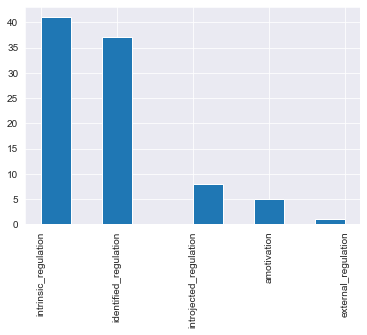

In [224]:
users_breq["breq_self_determination"].hist()
plt.xticks(rotation=90)

In [225]:
users_breq = users_breq[users_breq.columns.drop(list(users_breq.filter(regex='engage')))]
users_breq

,user_id,type,submitdate,breq_amotivation,breq_external_regulation,breq_introjected_regulation,breq_identified_regulation,breq_intrinsic_regulation,breq_self_determination
0,621e2e8e67b776a24055b564,breq,2021-05-31,1.00,1.00,1.000000,3.50,4.25,intrinsic_regulation
1,621e2e8e67b776a24055b564,breq,2021-07-26,1.00,1.00,1.666667,3.50,4.00,intrinsic_regulation
0,621e2eaf67b776a2406b14ac,breq,2021-11-29,1.25,1.00,1.666667,4.50,3.75,identified_regulation
1,621e2eaf67b776a2406b14ac,breq,2022-01-17,1.00,1.25,2.333333,4.00,3.50,identified_regulation
0,621e2ed667b776a24085d8d1,breq,2021-06-07,2.75,2.00,3.000000,2.50,1.00,introjected_regulation
...,...,...,...,...,...,...,...,...,...
0,621e36c267b776a240ba2756,breq,2021-05-31,1.00,1.00,1.000000,3.75,4.75,intrinsic_regulation
0,621e36f967b776a240e5e7c9,breq,2021-05-31,1.00,1.75,4.666667,4.00,3.25,introjected_regulation
1,621e36f967b776a240e5e7c9,breq,2021-07-26,1.00,1.75,5.000000,4.75,3.25,introjected_regulation
0,621e375b67b776a240290cdc,breq,2021-06-01,1.00,1.00,1.666667,3.50,2.75,identified_regulation


In [226]:
users_breq.to_csv("data/surveys/breq.csv")
users_breq.to_pickle("data/surveys/breq.pkl")

### Integrating TTM Responses

In [227]:
users_ttm = pd.DataFrame(columns=["user_id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.surveys.find({"$and": [
            {"type": "ttmspbf"},
            {"user_id": user}
        ]},
            {"_id": 0}
        )
    ))

    users_ttm = pd.concat([users_ttm, user_data], axis=0)

users_ttm["submitdate"] = users_ttm["data"].apply(lambda d: d["submitdate"])
users_ttm["stage"] = users_ttm["data"].apply(lambda d: d["stage"])
users_ttm["submitdate"] = pd.to_datetime(users_ttm["submitdate"], infer_datetime_format=True).dt.date

for engage in range(2,32):
    if engage < 10:
        col_name = "processes[SQ00{}]".format(engage)
        new_col_name = "processes[SQ00{}]".format(engage-1)
    else:
        col_name = "processes[SQ0{}]".format(engage)
        if engage == 10:
            new_col_name = "processes[SQ00{}]".format(engage-1)
        else:
            new_col_name = "processes[SQ0{}]".format(engage-1)
    users_ttm[new_col_name] = users_ttm["data"].apply(lambda d: d[col_name])

users_ttm.drop(['data'], axis=1, inplace=True)

print("We have {} survey responses for the TTM and Processes of Change scale.".format(users_ttm.shape[0]))

We have 98 survey responses for the TTM and Processes of Change scale.


In [228]:
users_ttm

,user_id,type,submitdate,stage,processes[SQ001],processes[SQ002],processes[SQ003],processes[SQ004],processes[SQ005],processes[SQ006],...,processes[SQ021],processes[SQ022],processes[SQ023],processes[SQ024],processes[SQ025],processes[SQ026],processes[SQ027],processes[SQ028],processes[SQ029],processes[SQ030]
0,621e2e8e67b776a24055b564,ttmspbf,2021-07-26,"Yes, I have been doing physical activity regul...",1,1,1,4,4,4,...,2,2,4,4,4,4,4,4,4,2
0,621e2eaf67b776a2406b14ac,ttmspbf,2021-11-29,"No, but I intend to do regular physical activi...",4,1,3,4,5,2,...,3,3,5,5,2,2,3,4,5,1
1,621e2eaf67b776a2406b14ac,ttmspbf,2022-01-17,"Yes, I have been doing physical activity regul...",4,2,4,4,5,3,...,3,1,5,5,1,1,3,3,4,4
0,621e2ed667b776a24085d8d1,ttmspbf,2021-06-07,"No, but I intend to do regular physical activi...",1,1,2,3,4,1,...,1,2,4,4,4,1,1,4,2,1
1,621e2ed667b776a24085d8d1,ttmspbf,2021-07-30,"No, but I intend to do regular physical activi...",2,1,4,4,4,1,...,1,2,4,3,4,2,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e36c267b776a240ba2756,ttmspbf,2021-05-31,"Yes, I have been doing physical activity regul...",2,1,4,4,4,4,...,3,1,3,5,3,4,3,4,4,4
0,621e36f967b776a240e5e7c9,ttmspbf,2021-05-31,"Yes, I have been doing physical activity regul...",2,4,4,5,3,3,...,2,4,4,5,2,3,3,4,4,5
1,621e36f967b776a240e5e7c9,ttmspbf,2021-07-26,"Yes, I have been doing physical activity regul...",4,3,4,5,4,3,...,4,4,4,5,2,3,2,5,4,4
0,621e375b67b776a240290cdc,ttmspbf,2021-06-01,"Yes, I have been doing physical activity regul...",2,2,1,3,5,1,...,3,2,1,3,5,1,3,5,4,2


In [229]:
def define_stage_of_change(response):
    if response == "No, and I do not intend to do regular physical activity in the next 6 months.":
        return "Precontemplation"
    if response == "No, but I intend to do regular physical activity in the next 6 months.":
        return "Contemplation"
    if response == "No, but I intend to do regular physical activity in the next 30 days.":
        return "Preparation"
    if response == "Yes, I have been doing physical activity regularly, but for less than 6 months.":
        return "Action"
    return "Maintenance"

users_ttm["stage"] = users_ttm.stage.apply(lambda response: define_stage_of_change(response))
users_ttm

,user_id,type,submitdate,stage,processes[SQ001],processes[SQ002],processes[SQ003],processes[SQ004],processes[SQ005],processes[SQ006],...,processes[SQ021],processes[SQ022],processes[SQ023],processes[SQ024],processes[SQ025],processes[SQ026],processes[SQ027],processes[SQ028],processes[SQ029],processes[SQ030]
0,621e2e8e67b776a24055b564,ttmspbf,2021-07-26,Maintenance,1,1,1,4,4,4,...,2,2,4,4,4,4,4,4,4,2
0,621e2eaf67b776a2406b14ac,ttmspbf,2021-11-29,Contemplation,4,1,3,4,5,2,...,3,3,5,5,2,2,3,4,5,1
1,621e2eaf67b776a2406b14ac,ttmspbf,2022-01-17,Action,4,2,4,4,5,3,...,3,1,5,5,1,1,3,3,4,4
0,621e2ed667b776a24085d8d1,ttmspbf,2021-06-07,Preparation,1,1,2,3,4,1,...,1,2,4,4,4,1,1,4,2,1
1,621e2ed667b776a24085d8d1,ttmspbf,2021-07-30,Contemplation,2,1,4,4,4,1,...,1,2,4,3,4,2,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e36c267b776a240ba2756,ttmspbf,2021-05-31,Action,2,1,4,4,4,4,...,3,1,3,5,3,4,3,4,4,4
0,621e36f967b776a240e5e7c9,ttmspbf,2021-05-31,Action,2,4,4,5,3,3,...,2,4,4,5,2,3,3,4,4,5
1,621e36f967b776a240e5e7c9,ttmspbf,2021-07-26,Action,4,3,4,5,4,3,...,4,4,4,5,2,3,2,5,4,4
0,621e375b67b776a240290cdc,ttmspbf,2021-06-01,Action,2,2,1,3,5,1,...,3,2,1,3,5,1,3,5,4,2


In [230]:
users_ttm.drop_duplicates(subset=["user_id", "submitdate"], keep="last", inplace=True)
print("We have {} survey responses for the TTM and Processes of Change scale after duplicate elimination.".format(users_ttm.shape[0]))

We have 94 survey responses for the TTM and Processes of Change scale after duplicate elimination.


<AxesSubplot:>

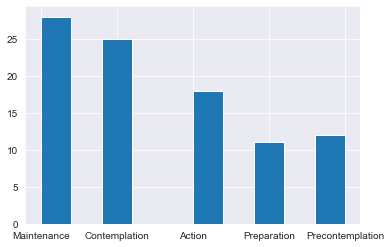

In [231]:
users_ttm.stage.hist()

In [232]:
users_ttm["ttm_consciousness_raising"] = users_ttm[["processes[SQ001]","processes[SQ011]", "processes[SQ021]"]].mean(axis=1)
users_ttm["ttm_dramatic_relief"] = users_ttm[["processes[SQ002]","processes[SQ012]", "processes[SQ022]"]].mean(axis=1)
users_ttm["ttm_environmental_reevaluation"] = users_ttm[["processes[SQ003]","processes[SQ013]", "processes[SQ023]"]].mean(axis=1)
users_ttm["ttm_self_reevaluation"] = users_ttm[["processes[SQ004]","processes[SQ014]", "processes[SQ024]"]].mean(axis=1)
users_ttm["ttm_social_liberation"] = users_ttm[["processes[SQ005]","processes[SQ015]", "processes[SQ025]"]].mean(axis=1)
users_ttm["ttm_counterconditioning"] = users_ttm[["processes[SQ006]","processes[SQ016]", "processes[SQ026]"]].mean(axis=1)
users_ttm["ttm_helping_relationships"] = users_ttm[["processes[SQ007]","processes[SQ017]", "processes[SQ027]"]].mean(axis=1)
users_ttm["ttm_reinforcement_management"] = users_ttm[["processes[SQ008]","processes[SQ018]", "processes[SQ028]"]].mean(axis=1)
users_ttm["ttm_self_liberation"] = users_ttm[["processes[SQ009]","processes[SQ019]", "processes[SQ029]"]].mean(axis=1)
users_ttm["ttm_stimulus_control"] = users_ttm[["processes[SQ010]","processes[SQ020]", "processes[SQ030]"]].mean(axis=1)

In [233]:
users_ttm = users_ttm[users_ttm.columns.drop(list(users_ttm.filter(regex='processes')))]
users_ttm

,user_id,type,submitdate,stage,ttm_consciousness_raising,ttm_dramatic_relief,ttm_environmental_reevaluation,ttm_self_reevaluation,ttm_social_liberation,ttm_counterconditioning,ttm_helping_relationships,ttm_reinforcement_management,ttm_self_liberation,ttm_stimulus_control
0,621e2e8e67b776a24055b564,ttmspbf,2021-07-26,Maintenance,1.333333,2.666667,2.333333,4.333333,4.000000,4.000000,4.000000,4.000000,4.000000,1.666667
0,621e2eaf67b776a2406b14ac,ttmspbf,2021-11-29,Contemplation,3.333333,2.666667,4.000000,4.666667,4.000000,2.333333,3.000000,4.333333,3.333333,1.000000
1,621e2eaf67b776a2406b14ac,ttmspbf,2022-01-17,Action,3.666667,2.333333,4.333333,4.333333,3.333333,1.666667,3.000000,4.333333,3.333333,3.000000
0,621e2ed667b776a24085d8d1,ttmspbf,2021-06-07,Preparation,1.000000,2.000000,3.000000,3.333333,3.333333,1.000000,1.000000,3.333333,1.666667,1.000000
1,621e2ed667b776a24085d8d1,ttmspbf,2021-07-30,Contemplation,1.666667,2.333333,4.000000,3.333333,3.666667,1.333333,1.000000,2.333333,2.333333,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e36c267b776a240ba2756,ttmspbf,2021-05-31,Action,2.666667,1.000000,3.000000,4.333333,3.666667,4.000000,3.333333,4.000000,3.666667,3.000000
0,621e36f967b776a240e5e7c9,ttmspbf,2021-05-31,Action,2.000000,4.333333,3.333333,5.000000,3.000000,3.333333,1.666667,3.666667,4.000000,3.333333
1,621e36f967b776a240e5e7c9,ttmspbf,2021-07-26,Action,4.000000,3.666667,3.666667,5.000000,3.000000,3.000000,1.666667,4.666667,4.000000,3.000000
0,621e375b67b776a240290cdc,ttmspbf,2021-06-01,Action,2.333333,1.666667,1.000000,2.666667,5.000000,1.000000,3.000000,4.666667,2.666667,1.333333


In [234]:
users_ttm.to_csv("data/surveys/ttm.csv")
users_ttm.to_pickle("data/surveys/ttm.pkl")

### Integrating STAI Data

In [235]:
users_stai = pd.DataFrame(columns=["user_id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.surveys.find({"$and": [
            {"type": "stai"},
            {"user_id": user}
        ]},
            {"_id": 0}
        )
    ))

    users_stai = pd.concat([users_stai, user_data], axis=0)

users_stai["submitdate"] = users_stai["data"].apply(lambda d: d["submitdate"])
users_stai["submitdate"] = pd.to_datetime(users_stai["submitdate"], infer_datetime_format=True).dt.date

for engage in range(1,21):
    if engage < 10:
        col_name = "STAI[SQ00{}]".format(engage)
    else:
        col_name = "STAI[SQ0{}]".format(engage)
    users_stai[col_name] = users_stai["data"].apply(lambda d: d[col_name])

users_stai.drop(['data'], axis=1, inplace=True)

print("We have {} survey responses for the STAI (Y1-form) scale.".format(users_stai.shape[0]))

We have 304 survey responses for the STAI (Y1-form) scale.


In [236]:
users_stai.head()

,user_id,type,submitdate,STAI[SQ001],STAI[SQ002],STAI[SQ003],STAI[SQ004],STAI[SQ005],STAI[SQ006],STAI[SQ007],...,STAI[SQ011],STAI[SQ012],STAI[SQ013],STAI[SQ014],STAI[SQ015],STAI[SQ016],STAI[SQ017],STAI[SQ018],STAI[SQ019],STAI[SQ020]
0,621e2e8e67b776a24055b564,stai,2021-05-31,4,5,1,1,4,1,1,...,5,1,1,1,3,3,3,1,3,3
1,621e2e8e67b776a24055b564,stai,2021-06-07,4,5,1,1,4,1,1,...,4,2,1,1,4,4,2,2,4,4
2,621e2e8e67b776a24055b564,stai,2021-06-28,3,5,4,3,3,1,1,...,4,2,2,2,3,3,2,2,3,3
3,621e2e8e67b776a24055b564,stai,2021-07-19,4,5,1,1,4,1,1,...,4,2,1,1,4,4,2,4,4,4
4,621e2e8e67b776a24055b564,stai,2021-07-26,5,5,1,1,4,1,1,...,5,1,1,1,5,5,1,1,4,5


In [237]:
# convert 5-likert to 4-likert scale (mistakenly the STAI scale was distributed with a 5-likert, but it's originally 4-likert)
def convert_5_to_4_likert(x):
    return (4 - 1) * (x - 1) / (5 - 1) + 1

users_stai.iloc[:, 3:] = users_stai.iloc[:, 3:].apply(lambda x: convert_5_to_4_likert(x))
users_stai

,user_id,type,submitdate,STAI[SQ001],STAI[SQ002],STAI[SQ003],STAI[SQ004],STAI[SQ005],STAI[SQ006],STAI[SQ007],...,STAI[SQ011],STAI[SQ012],STAI[SQ013],STAI[SQ014],STAI[SQ015],STAI[SQ016],STAI[SQ017],STAI[SQ018],STAI[SQ019],STAI[SQ020]
0,621e2e8e67b776a24055b564,stai,2021-05-31,3.25,4.0,1.00,1.00,3.25,1.00,1.0,...,4.00,1.00,1.00,1.00,2.50,2.50,2.50,1.00,2.50,2.50
1,621e2e8e67b776a24055b564,stai,2021-06-07,3.25,4.0,1.00,1.00,3.25,1.00,1.0,...,3.25,1.75,1.00,1.00,3.25,3.25,1.75,1.75,3.25,3.25
2,621e2e8e67b776a24055b564,stai,2021-06-28,2.50,4.0,3.25,2.50,2.50,1.00,1.0,...,3.25,1.75,1.75,1.75,2.50,2.50,1.75,1.75,2.50,2.50
3,621e2e8e67b776a24055b564,stai,2021-07-19,3.25,4.0,1.00,1.00,3.25,1.00,1.0,...,3.25,1.75,1.00,1.00,3.25,3.25,1.75,3.25,3.25,3.25
4,621e2e8e67b776a24055b564,stai,2021-07-26,4.00,4.0,1.00,1.00,3.25,1.00,1.0,...,4.00,1.00,1.00,1.00,4.00,4.00,1.00,1.00,3.25,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e375b67b776a240290cdc,stai,2021-06-08,2.50,2.5,2.50,2.50,2.50,2.50,2.5,...,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50
1,621e375b67b776a240290cdc,stai,2021-07-06,2.50,2.5,2.50,2.50,2.50,2.50,2.5,...,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50
2,621e375b67b776a240290cdc,stai,2021-06-01,2.50,2.5,2.50,2.50,2.50,2.50,4.0,...,1.75,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,1.75
3,621e375b67b776a240290cdc,stai,2021-06-22,2.50,2.5,2.50,2.50,2.50,2.50,2.5,...,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50


In [238]:
def proper_round(num, dec=0):
    num = str(num)[:str(num).index('.')+dec+2]
    if num[-1]>='5':
      a = num[:-2-(not dec)]       # integer part
      b = int(num[-2-(not dec)])+1 # decimal part
      return float(a)+b**(-dec+1) if a and b == 10 else float(a+str(b))
    return float(num[:-1])

for col in users_stai.iloc[:, 3:].columns:
    users_stai[col] = users_stai[col].apply(lambda x: proper_round(x))
users_stai

,user_id,type,submitdate,STAI[SQ001],STAI[SQ002],STAI[SQ003],STAI[SQ004],STAI[SQ005],STAI[SQ006],STAI[SQ007],...,STAI[SQ011],STAI[SQ012],STAI[SQ013],STAI[SQ014],STAI[SQ015],STAI[SQ016],STAI[SQ017],STAI[SQ018],STAI[SQ019],STAI[SQ020]
0,621e2e8e67b776a24055b564,stai,2021-05-31,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,4.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,3.0,3.0
1,621e2e8e67b776a24055b564,stai,2021-06-07,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,2.0,3.0,3.0
2,621e2e8e67b776a24055b564,stai,2021-06-28,3.0,4.0,3.0,3.0,3.0,1.0,1.0,...,3.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0
3,621e2e8e67b776a24055b564,stai,2021-07-19,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0
4,621e2e8e67b776a24055b564,stai,2021-07-26,4.0,4.0,1.0,1.0,3.0,1.0,1.0,...,4.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e375b67b776a240290cdc,stai,2021-06-08,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,621e375b67b776a240290cdc,stai,2021-07-06,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,621e375b67b776a240290cdc,stai,2021-06-01,3.0,3.0,3.0,3.0,3.0,3.0,4.0,...,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0
3,621e375b67b776a240290cdc,stai,2021-06-22,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [239]:
# Based on the scoring document: https://oml.eular.org/sysModules/obxOML/docs/id_150/State-Trait-Anxiety-Inventory.pdf, some questions are reversed in STAI
stai_reversed = ["STAI[SQ001]", "STAI[SQ002]", "STAI[SQ005]", "STAI[SQ008]", "STAI[SQ010]", "STAI[SQ011]", "STAI[SQ015]", "STAI[SQ016]", "STAI[SQ019]", "STAI[SQ020]"]
for col in users_personality.columns:
    # inversing scores for the minus keyed items; the plus keyed items stay as is
    if col in stai_reversed:
        users_stai[col] = users_stai[col].apply(lambda score: inverse_score(score, 1, 4))
users_stai

,user_id,type,submitdate,STAI[SQ001],STAI[SQ002],STAI[SQ003],STAI[SQ004],STAI[SQ005],STAI[SQ006],STAI[SQ007],...,STAI[SQ011],STAI[SQ012],STAI[SQ013],STAI[SQ014],STAI[SQ015],STAI[SQ016],STAI[SQ017],STAI[SQ018],STAI[SQ019],STAI[SQ020]
0,621e2e8e67b776a24055b564,stai,2021-05-31,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,4.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,3.0,3.0
1,621e2e8e67b776a24055b564,stai,2021-06-07,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,2.0,3.0,3.0
2,621e2e8e67b776a24055b564,stai,2021-06-28,3.0,4.0,3.0,3.0,3.0,1.0,1.0,...,3.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0
3,621e2e8e67b776a24055b564,stai,2021-07-19,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0
4,621e2e8e67b776a24055b564,stai,2021-07-26,4.0,4.0,1.0,1.0,3.0,1.0,1.0,...,4.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e375b67b776a240290cdc,stai,2021-06-08,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,621e375b67b776a240290cdc,stai,2021-07-06,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,621e375b67b776a240290cdc,stai,2021-06-01,3.0,3.0,3.0,3.0,3.0,3.0,4.0,...,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0
3,621e375b67b776a240290cdc,stai,2021-06-22,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [240]:
# to calculate the total stress score simply sum per row
users_stai['stai_stress'] = users_stai.iloc[:, 3:].sum(axis=1)
users_stai

,user_id,type,submitdate,STAI[SQ001],STAI[SQ002],STAI[SQ003],STAI[SQ004],STAI[SQ005],STAI[SQ006],STAI[SQ007],...,STAI[SQ012],STAI[SQ013],STAI[SQ014],STAI[SQ015],STAI[SQ016],STAI[SQ017],STAI[SQ018],STAI[SQ019],STAI[SQ020],stai_stress
0,621e2e8e67b776a24055b564,stai,2021-05-31,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,3.0,3.0,3.0,1.0,3.0,3.0,45.0
1,621e2e8e67b776a24055b564,stai,2021-06-07,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,2.0,1.0,1.0,3.0,3.0,2.0,2.0,3.0,3.0,46.0
2,621e2e8e67b776a24055b564,stai,2021-06-28,3.0,4.0,3.0,3.0,3.0,1.0,1.0,...,2.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,51.0
3,621e2e8e67b776a24055b564,stai,2021-07-19,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,2.0,1.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0,46.0
4,621e2e8e67b776a24055b564,stai,2021-07-26,4.0,4.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,4.0,4.0,1.0,1.0,3.0,4.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e375b67b776a240290cdc,stai,2021-06-08,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,60.0
1,621e375b67b776a240290cdc,stai,2021-07-06,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,60.0
2,621e375b67b776a240290cdc,stai,2021-06-01,3.0,3.0,3.0,3.0,3.0,3.0,4.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,59.0
3,621e375b67b776a240290cdc,stai,2021-06-22,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,60.0


Score interpretation.
Range of scores for each subtest is 20–80, the higher score indicating greater anxiety. A cut point of 39–40 has been suggested to detect clinically significant symptoms for the S-Anxiety scale (9, 10); however, other studies have suggested a higher cut score of 54–55 for older adults (11). Normative values are available in the manual (12) for adults, college students, and psychiatric samples. To this author's knowledge, no cut scores have been validated for rheumatic disease populations.

[https://onlinelibrary.wiley.com/doi/full/10.1002/acr.20561](Source)

**Warning:** The above assumes that both S-STAI and T-STAI were administered, but we administered only the S-STAI.

<AxesSubplot:>

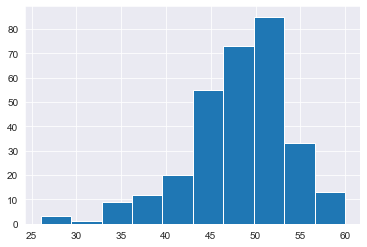

In [241]:
users_stai['stai_stress'].hist()

In [242]:
mean_stai = users_stai['stai_stress'].mean()
std_stai = users_stai['stai_stress'].std()

def get_stai_category(score):
    if score < mean_stai-0.5*std_stai:
        return "Below average"
    if score > mean_stai+0.5*std_stai:
        return "Above average"
    return "Average"

users_stai['stai_stress_category'] = users_stai['stai_stress'].apply(lambda score: get_stai_category(score))
users_stai

,user_id,type,submitdate,STAI[SQ001],STAI[SQ002],STAI[SQ003],STAI[SQ004],STAI[SQ005],STAI[SQ006],STAI[SQ007],...,STAI[SQ013],STAI[SQ014],STAI[SQ015],STAI[SQ016],STAI[SQ017],STAI[SQ018],STAI[SQ019],STAI[SQ020],stai_stress,stai_stress_category
0,621e2e8e67b776a24055b564,stai,2021-05-31,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,3.0,3.0,3.0,1.0,3.0,3.0,45.0,Below average
1,621e2e8e67b776a24055b564,stai,2021-06-07,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,3.0,3.0,2.0,2.0,3.0,3.0,46.0,Average
2,621e2e8e67b776a24055b564,stai,2021-06-28,3.0,4.0,3.0,3.0,3.0,1.0,1.0,...,2.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,51.0,Above average
3,621e2e8e67b776a24055b564,stai,2021-07-19,3.0,4.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0,46.0,Average
4,621e2e8e67b776a24055b564,stai,2021-07-26,4.0,4.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,4.0,4.0,1.0,1.0,3.0,4.0,46.0,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,621e375b67b776a240290cdc,stai,2021-06-08,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,60.0,Above average
1,621e375b67b776a240290cdc,stai,2021-07-06,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,60.0,Above average
2,621e375b67b776a240290cdc,stai,2021-06-01,3.0,3.0,3.0,3.0,3.0,3.0,4.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,59.0,Above average
3,621e375b67b776a240290cdc,stai,2021-06-22,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,60.0,Above average


In [243]:
users_stai.drop_duplicates(subset=["user_id", "submitdate"], inplace=True, keep="last")
print("We have {} survey responses for the STAI (Y1-form) scale after duplicates elimination.".format(users_stai.shape[0]))

We have 279 survey responses for the STAI (Y1-form) scale after duplicates elimination.


<AxesSubplot:>

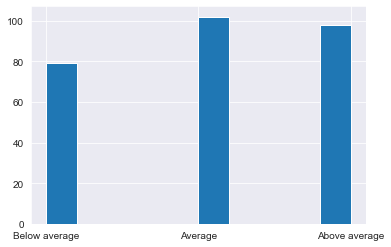

In [244]:
users_stai.stai_stress_category.hist()

In [245]:
print("Average value on the S-STAI scale: {} - Standard deviation on the S-STAI scale: {}".format(mean_stai, std_stai))

Average value on the S-STAI scale: 48.00986842105263 - Standard deviation on the S-STAI scale: 5.689713488972025


In [246]:
users_stai = users_stai[users_stai.columns.drop(list(users_stai.filter(regex='STAI\[SQ')))]
users_stai

,user_id,type,submitdate,stai_stress,stai_stress_category
0,621e2e8e67b776a24055b564,stai,2021-05-31,45.0,Below average
1,621e2e8e67b776a24055b564,stai,2021-06-07,46.0,Average
3,621e2e8e67b776a24055b564,stai,2021-07-19,46.0,Average
4,621e2e8e67b776a24055b564,stai,2021-07-26,46.0,Average
5,621e2e8e67b776a24055b564,stai,2021-06-28,54.0,Above average
...,...,...,...,...,...
0,621e375b67b776a240290cdc,stai,2021-06-08,60.0,Above average
1,621e375b67b776a240290cdc,stai,2021-07-06,60.0,Above average
2,621e375b67b776a240290cdc,stai,2021-06-01,59.0,Above average
3,621e375b67b776a240290cdc,stai,2021-06-22,60.0,Above average


C:\Users\Sofia\AppData\Local\Temp\ipykernel_13076\3366683550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_stai.sort_values(["user_id", "submitdate"], inplace=True)


(array([18962., 18969., 18976., 18983., 18993., 19000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

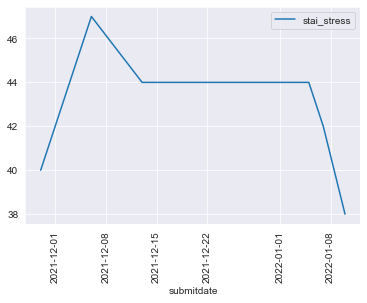

In [247]:
# test for random user
users_stai.sort_values(["user_id", "submitdate"], inplace=True)
users_stai[users_stai.user_id == ObjectId("621e2eaf67b776a2406b14ac")].plot("submitdate", "stai_stress")
plt.xticks(rotation=90)

In [248]:
users_stai.to_csv("data/surveys/stai.csv")
users_stai.to_pickle("data/surveys/stai.pkl")

### Integrate PANAS scale

In [249]:
users_panas = pd.DataFrame(columns=["user_id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.surveys.find({"$and": [
            {"type": "panas"},
            {"user_id": user}
        ]},
            {"_id": 0}
        )
    ))

    users_panas = pd.concat([users_panas, user_data], axis=0)

users_panas["submitdate"] = users_panas["data"].apply(lambda d: d["submitdate"])
users_panas["submitdate"] = pd.to_datetime(users_panas["submitdate"], infer_datetime_format=True).dt.date

for p in range(1,21):
    if p < 10:
        col_name = "P1[SQ00{}]".format(p)
    else:
        col_name = "P1[SQ0{}]".format(p)
    users_panas[col_name] = users_panas["data"].apply(lambda d: d[col_name])

users_panas.drop(['data'], axis=1, inplace=True)

print("We have {} survey responses for the STAI (Y1-form) scale.".format(users_panas.shape[0]))
users_panas.drop_duplicates(subset=["user_id", "submitdate"], inplace=True, keep="last")
print("We have {} survey responses for the STAI (Y1-form) scale after duplicates elimination.".format(users_panas.shape[0]))

We have 292 survey responses for the STAI (Y1-form) scale.
We have 268 survey responses for the STAI (Y1-form) scale after duplicates elimination.


In [250]:
users_panas

,user_id,type,submitdate,P1[SQ001],P1[SQ002],P1[SQ003],P1[SQ004],P1[SQ005],P1[SQ006],P1[SQ007],...,P1[SQ011],P1[SQ012],P1[SQ013],P1[SQ014],P1[SQ015],P1[SQ016],P1[SQ017],P1[SQ018],P1[SQ019],P1[SQ020]
1,621e2e8e67b776a24055b564,panas,2021-07-26,5,5,4,1,4,1,1,...,1,1,1,4,1,4,3,1,4,1
2,621e2e8e67b776a24055b564,panas,2021-05-31,3,3,5,1,5,1,1,...,1,1,1,3,1,5,4,1,4,1
3,621e2e8e67b776a24055b564,panas,2021-06-07,5,3,3,1,4,1,1,...,1,1,1,4,1,4,4,1,4,1
4,621e2e8e67b776a24055b564,panas,2021-06-28,3,3,3,1,4,1,1,...,1,1,1,4,1,4,3,1,3,1
5,621e2e8e67b776a24055b564,panas,2021-07-19,4,2,4,1,4,1,1,...,1,1,1,4,2,4,4,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,621e375367b776a24021e950,panas,2022-01-02,3,3,3,4,3,4,3,...,3,3,3,3,4,3,3,3,3,3
0,621e375b67b776a240290cdc,panas,2021-06-01,3,3,3,3,2,3,3,...,3,3,2,3,3,3,3,3,3,3
1,621e375b67b776a240290cdc,panas,2021-06-08,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,621e375b67b776a240290cdc,panas,2021-06-22,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [251]:
positive = ["P1[SQ001]", "P1[SQ003]", "P1[SQ005]", "P1[SQ009]", "P1[SQ010]", "P1[SQ012]", "P1[SQ014]", "P1[SQ016]", "P1[SQ017]", "P1[SQ019]"]
negative = ["P1[SQ002]", "P1[SQ004]", "P1[SQ006]", "P1[SQ007]", "P1[SQ008]", "P1[SQ011]", "P1[SQ013]", "P1[SQ015]", "P1[SQ018]", "P1[SQ020]"]
users_panas["positive_affect_score"] = users_panas[positive].sum(axis=1)
users_panas["negative_affect_score"] = users_panas[negative].sum(axis=1)
users_panas

,user_id,type,submitdate,P1[SQ001],P1[SQ002],P1[SQ003],P1[SQ004],P1[SQ005],P1[SQ006],P1[SQ007],...,P1[SQ013],P1[SQ014],P1[SQ015],P1[SQ016],P1[SQ017],P1[SQ018],P1[SQ019],P1[SQ020],positive_affect_score,negative_affect_score
1,621e2e8e67b776a24055b564,panas,2021-07-26,5,5,4,1,4,1,1,...,1,4,1,4,3,1,4,1,37,14
2,621e2e8e67b776a24055b564,panas,2021-05-31,3,3,5,1,5,1,1,...,1,3,1,5,4,1,4,1,38,12
3,621e2e8e67b776a24055b564,panas,2021-06-07,5,3,3,1,4,1,1,...,1,4,1,4,4,1,4,1,37,12
4,621e2e8e67b776a24055b564,panas,2021-06-28,3,3,3,1,4,1,1,...,1,4,1,4,3,1,3,1,31,12
5,621e2e8e67b776a24055b564,panas,2021-07-19,4,2,4,1,4,1,1,...,1,4,2,4,4,1,4,1,37,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,621e375367b776a24021e950,panas,2022-01-02,3,3,3,4,3,4,3,...,3,3,4,3,3,3,3,3,30,33
0,621e375b67b776a240290cdc,panas,2021-06-01,3,3,3,3,2,3,3,...,2,3,3,3,3,3,3,3,27,29
1,621e375b67b776a240290cdc,panas,2021-06-08,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,30,30
2,621e375b67b776a240290cdc,panas,2021-06-22,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,30,30


In [252]:
print("Mean positive affect score is {} (SD={}) compared to original sample mean of 33.3 (SD=7.2)".format(users_panas["positive_affect_score"].mean(), users_panas["positive_affect_score"].std()))
print("Mean negative affect score is {} (SD={}) compared to original sample mean of 17.4 (SD=6.2)".format(users_panas["negative_affect_score"].mean(), users_panas["negative_affect_score"].std()))
print("Scores can range from 10 – 50, with higher scores representing higher levels of positive or negative affect, respectively.")

Mean positive affect score is 31.559701492537314 (SD=7.407366708790624) compared to original sample mean of 33.3 (SD=7.2)
Mean negative affect score is 21.23507462686567 (SD=7.552609564274128) compared to original sample mean of 17.4 (SD=6.2)
Scores can range from 10 – 50, with higher scores representing higher levels of positive or negative affect, respectively.


In [253]:
users_panas["positive_affect_score"].describe()

count    268.000000
mean      31.559701
std        7.407367
min       12.000000
25%       27.000000
50%       31.000000
75%       37.000000
max       49.000000
Name: positive_affect_score, dtype: float64

In [254]:
users_panas["negative_affect_score"].describe()

count    268.000000
mean      21.235075
std        7.552610
min       10.000000
25%       15.000000
50%       20.000000
75%       27.000000
max       45.000000
Name: negative_affect_score, dtype: float64

In [255]:
users_panas = users_panas[users_panas.columns.drop(list(users_panas.filter(regex='P1\[SQ')))]
users_panas

,user_id,type,submitdate,positive_affect_score,negative_affect_score
1,621e2e8e67b776a24055b564,panas,2021-07-26,37,14
2,621e2e8e67b776a24055b564,panas,2021-05-31,38,12
3,621e2e8e67b776a24055b564,panas,2021-06-07,37,12
4,621e2e8e67b776a24055b564,panas,2021-06-28,31,12
5,621e2e8e67b776a24055b564,panas,2021-07-19,37,12
...,...,...,...,...,...
1,621e375367b776a24021e950,panas,2022-01-02,30,33
0,621e375b67b776a240290cdc,panas,2021-06-01,27,29
1,621e375b67b776a240290cdc,panas,2021-06-08,30,30
2,621e375b67b776a240290cdc,panas,2021-06-22,30,30


In [256]:
users_panas.to_csv("data/surveys/panas.csv")
users_panas.to_pickle("data/surveys/panas.pkl")